In [1]:
#common imports:
import numpy as np
import pandas as pd
from datetime import datetime
import os

#import for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors
import seaborn as sns
import matplotlib.pyplot as plt



#for Modelling/timeseries:
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter


from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf


from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

sns.set(rc={'figure.figsize':(20,15)})


#suppress pandas future warnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


    
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import ensemble
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [2]:
# load cleaned data time series:
df_time_m = pd.read_csv('timeseriesformodel.csv')

## Time series

Analyzing Time series: 
The vaccination progress is reported daily, so that we have timeseries to analyze. 

In [3]:
#set DatetimeIndex as index for our DataFrame:
df_daily = pd.read_csv('df2.csv', index_col=None)
#df_daily = df_daily.set_index('date')
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily.head(3)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines
0,Afghanistan,AFG,2021-02-23,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca
1,Afghanistan,AFG,2021-02-24,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca
2,Afghanistan,AFG,2021-02-25,NaN,NaN,0.0,1367.0,NaN,NaN,0.0,35.0,Oxford/AstraZeneca


In [4]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   country                              7497 non-null   object        
 1   iso_code                             7497 non-null   object        
 2   date                                 7497 non-null   datetime64[ns]
 3   total_vaccinations                   4523 non-null   float64       
 4   people_vaccinated                    3983 non-null   float64       
 5   people_fully_vaccinated              7497 non-null   float64       
 6   daily_vaccinations                   7491 non-null   float64       
 7   total_vaccinations_per_hundred       4523 non-null   float64       
 8   people_vaccinated_per_hundred        3983 non-null   float64       
 9   people_fully_vaccinated_per_hundred  7497 non-null   float64       
 10  daily_vaccin

In [5]:
#df_daily.reset_index(inplace=True)

In [6]:
df_daily['day'] = df_daily['date'].dt.day
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year
df_daily['weekday_name'] = df_daily['date'].dt.day_name()#day_of_week  
# Display a random sampling of 5 rows
df_daily.sample(5, random_state=0)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,day,month,year,weekday_name
4512,Mauritius,MUS,2021-02-02,NaN,NaN,0.0,58.0,NaN,NaN,0.00,46.0,Oxford/AstraZeneca,2,2,2021,Tuesday
2412,Finland,FIN,2021-02-09,227427.0,173558.0,53869.0,9065.0,4.10,3.13,0.97,1636.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",9,2,2021,Tuesday
4732,Mongolia,MNG,2021-03-11,48265.0,NaN,0.0,5009.0,1.47,NaN,0.00,1528.0,Oxford/AstraZeneca,11,3,2021,Thursday
4245,Luxembourg,LUX,2021-01-08,NaN,NaN,0.0,62.0,NaN,NaN,0.00,99.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",8,1,2021,Friday
5700,Qatar,QAT,2021-03-11,NaN,NaN,0.0,15381.0,NaN,NaN,0.00,5339.0,Pfizer/BioNTech,11,3,2021,Thursday


In [7]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [8]:
df_time = df_daily.copy()
df_time.set_index('date')
df_time = df_time[['date','country', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time.sample(20)

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
2801,2021-03-22,Greece,26226.0,4.52
4030,2021-02-18,Latvia,1135.0,0.89
2424,2021-02-21,Finland,12496.0,1.37
4160,2021-01-07,Lithuania,1183.0,0.00
7013,2021-03-05,Turkey,208212.0,2.74
556,2021-01-28,Bahrain,7712.0,0.00
7323,2020-12-31,United States,278776.0,0.00
6145,2021-03-07,Senegal,5431.0,0.00
1337,2021-01-24,Cayman Islands,275.0,0.00
82,2021-03-17,Albania,1679.0,0.00


In [9]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

,ID
date,0
country,0
daily_vaccinations,6
people_fully_vaccinated_per_hundred,0


In [10]:
df_time.dropna(axis=0)

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
0,2021-02-23,Afghanistan,1367.0,0.0
1,2021-02-24,Afghanistan,1367.0,0.0
2,2021-02-25,Afghanistan,1367.0,0.0
3,2021-02-26,Afghanistan,1367.0,0.0
4,2021-02-27,Afghanistan,1367.0,0.0
...,...,...,...,...
7492,2021-03-20,Zimbabwe,836.0,0.0
7493,2021-03-21,Zimbabwe,910.0,0.0
7494,2021-03-22,Zimbabwe,805.0,0.0
7495,2021-03-23,Zimbabwe,655.0,0.0


In [11]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

,ID
date,0
country,0
daily_vaccinations,6
people_fully_vaccinated_per_hundred,0


In [12]:
df_time.isnull().any()

date                                   False
country                                False
daily_vaccinations                      True
people_fully_vaccinated_per_hundred    False
dtype: bool

In [13]:
df_time.dropna(inplace = True)

In [14]:
#check for missing values in %
round(100*(df_time.isnull().sum()/len(df_time.index)),0)

date                                   0.0
country                                0.0
daily_vaccinations                     0.0
people_fully_vaccinated_per_hundred    0.0
dtype: float64

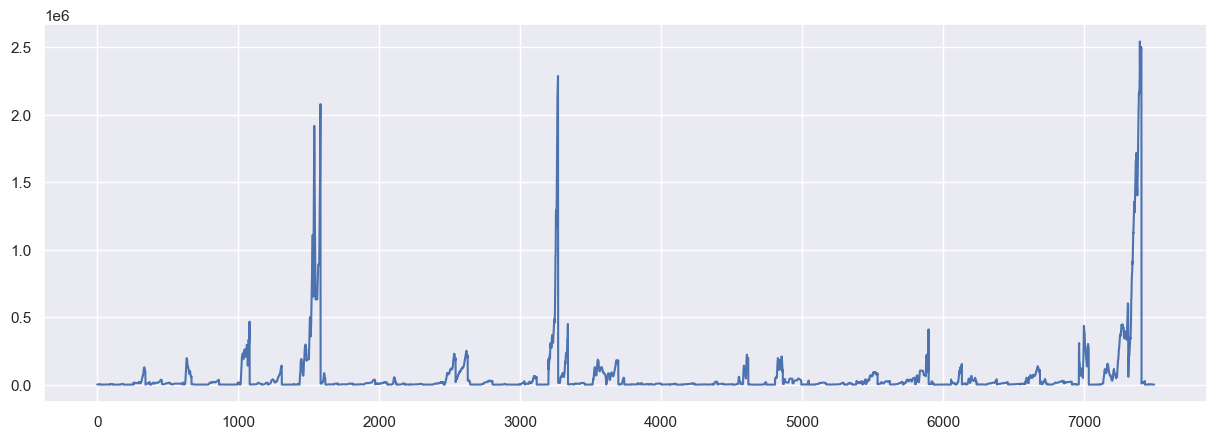

In [15]:
#nicht richtig , siehe Achsenwerte, Problem mehrere Werte pro Tag, da pro Land? plus Achsenbeschriftung
df_time["daily_vaccinations"].plot();

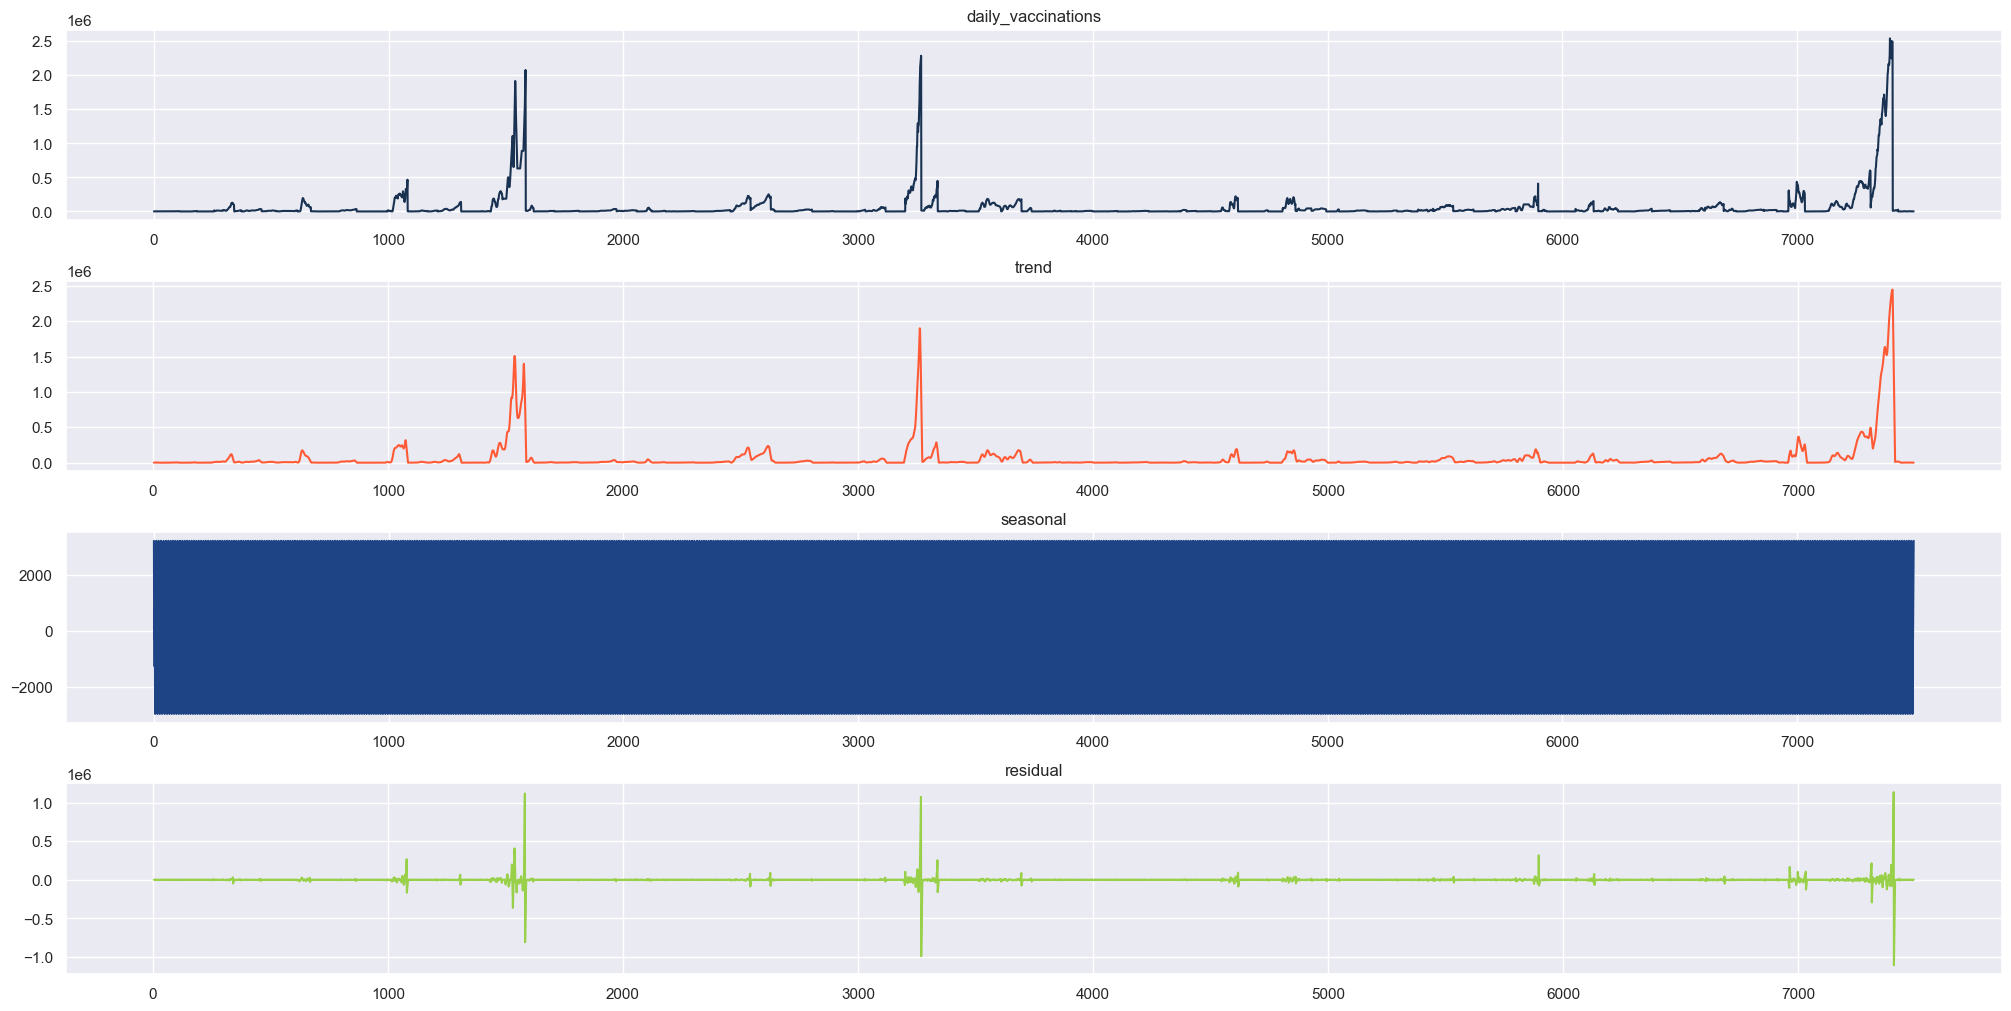

In [16]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time['daily_vaccinations'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

xxx

## Check for Stationarity

Stationarity: A time series is stationary if its statistical properties (e.g. mean, variance, etc.) are the same throughout the series, independently of the point in time where you observe it. There are no long-term predictable patterns such as trend or seasonality. Plots will show a roughly horizontal trend with constant variance.

noch umschreiben:

In order to check for stationarity we will apply three different methods. First, we will calculate and plot the rolling mean and rolling standard deviation. It they show an upward or downward trend or vary over time, then it is highly likely that our time series is non-stationary. Furthermore, we will use the ADF (Augmented Dickey-Fuller) and the KPSS (Kwiatkowski-Phillips-Schmidt-Shintests) tests. We have to be careful when interpreting the results: the null-hypothesis of the ADF test is that the time series is non-stationary whereas the KPSS test assumes that it is stationary.

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -7.949467
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.473625
p-value: 0.047607
----------------------------------------


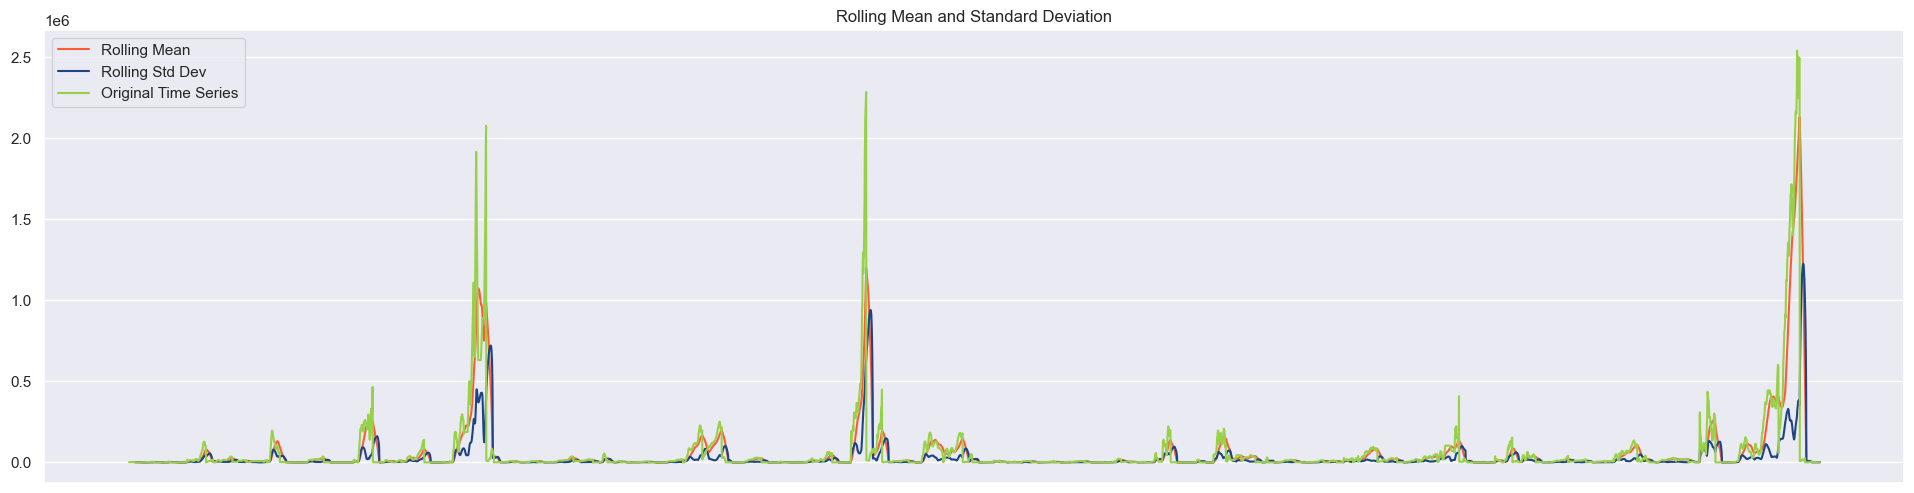

In [17]:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time['daily_vaccinations'])

The rolling mean moves up and down over time as as the daily vaccinations vary. The p-value of the ADF test is 0 which tells us that we can decline the null-hypothesis that the time series is non-stationary and the p-value for the KPSS test is over 0.05 which means we cannot reject this null-hypothesis that it is stationary. Both tests indicates that it is stationary.

In [18]:
#check for stationarity for country data:
df_time_us = df_time[df_time.country == 'United States']
df_time_us

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
7313,2020-12-21,United States,57909.0,0.00
7314,2020-12-22,United States,127432.0,0.00
7315,2020-12-23,United States,150606.0,0.00
7316,2020-12-24,United States,191001.0,0.00
7317,2020-12-25,United States,215238.0,0.00
...,...,...,...,...
7402,2021-03-20,United States,2248285.0,12.87
7403,2021-03-21,United States,2488734.0,13.20
7404,2021-03-22,United States,2489697.0,13.43
7405,2021-03-23,United States,2497025.0,13.61


In [19]:
#check for missing values in %
round(100*(df_time_us.isnull().sum()/len(df_time_us.index)),0)

date                                   0.0
country                                0.0
daily_vaccinations                     0.0
people_fully_vaccinated_per_hundred    0.0
dtype: float64

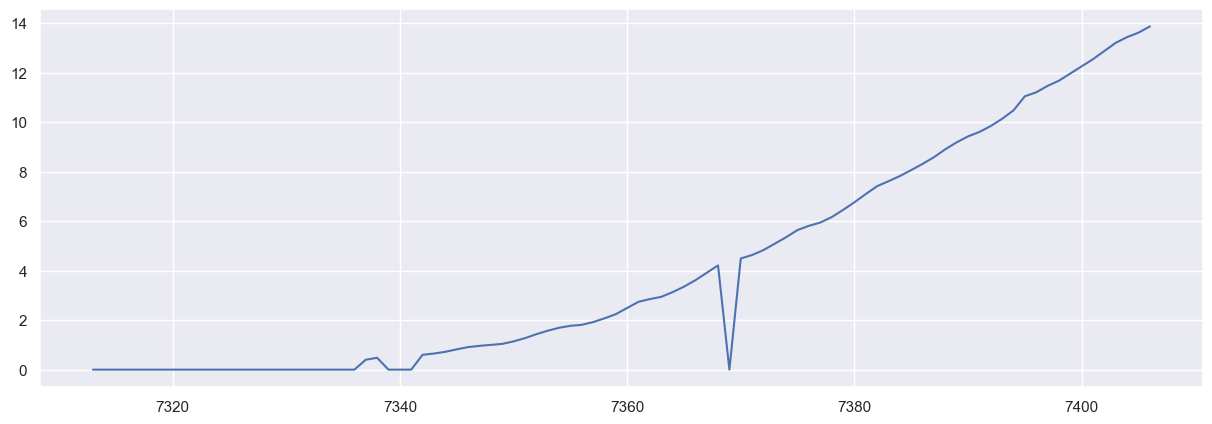

In [20]:

df_time_us["people_fully_vaccinated_per_hundred"].plot();

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -0.520049
p-value: 0.888044
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.815044
p-value: 0.010000
----------------------------------------


/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


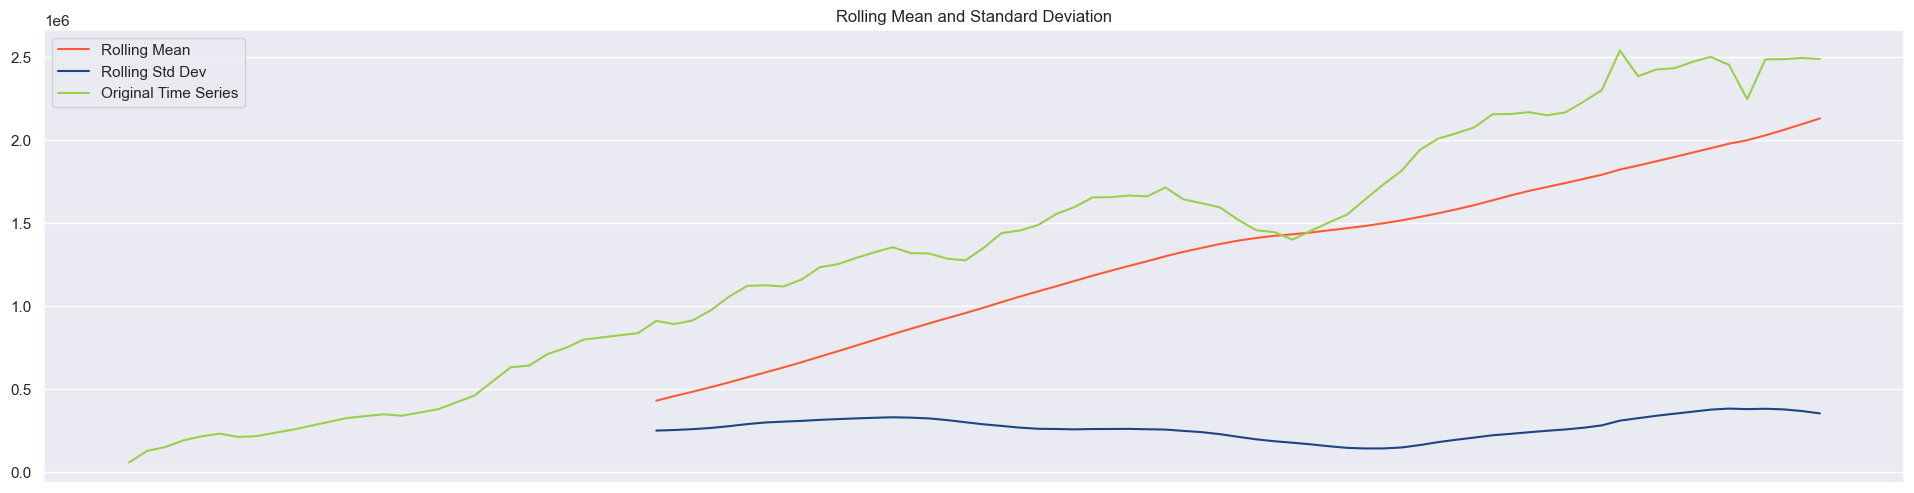

In [21]:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time_us['daily_vaccinations'])

The p-value of the ADF test is > 0.5 which tells us that we cannot decline the null-hypothesis that the time series is non-stationary and the p-value for the KPSS test is below 0.05 which means we can reject this null-hypothesis that it is stationary. Both tests indicates that it is not stationary.

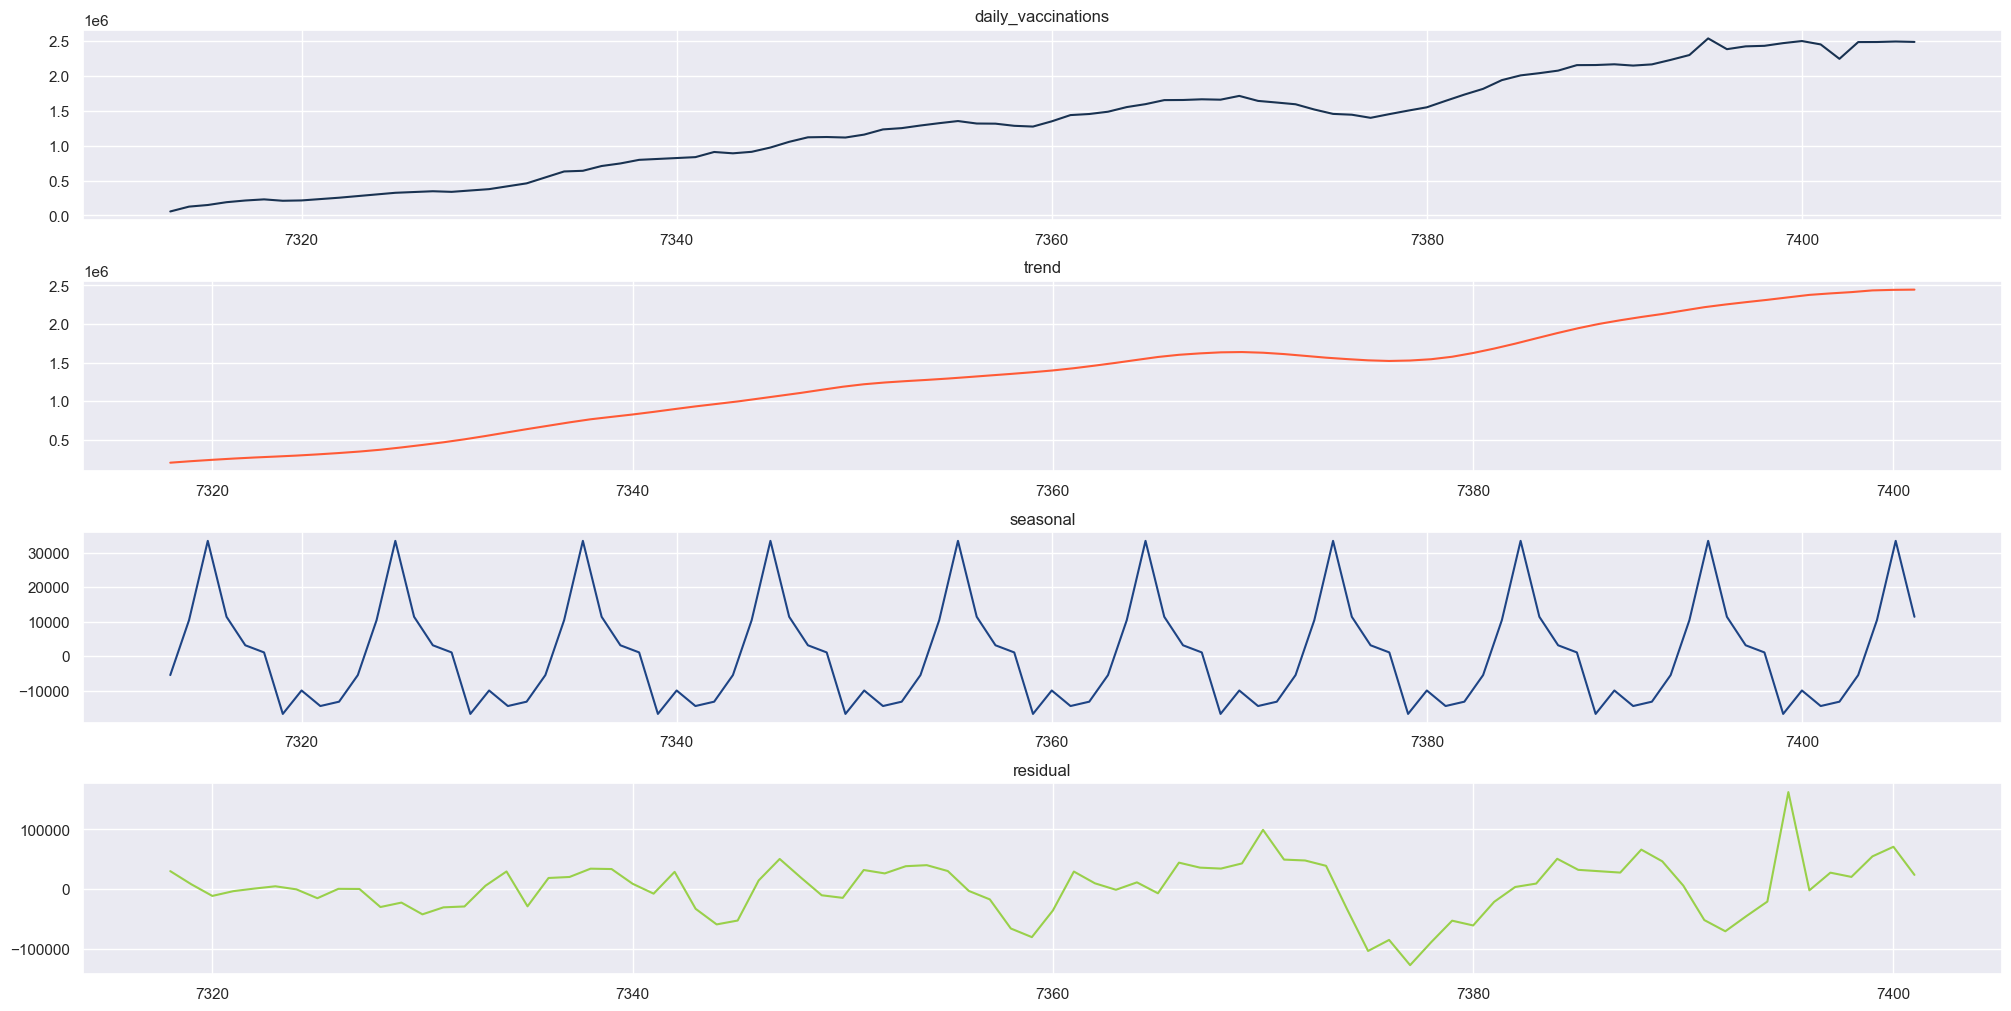

In [22]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time_us['daily_vaccinations'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

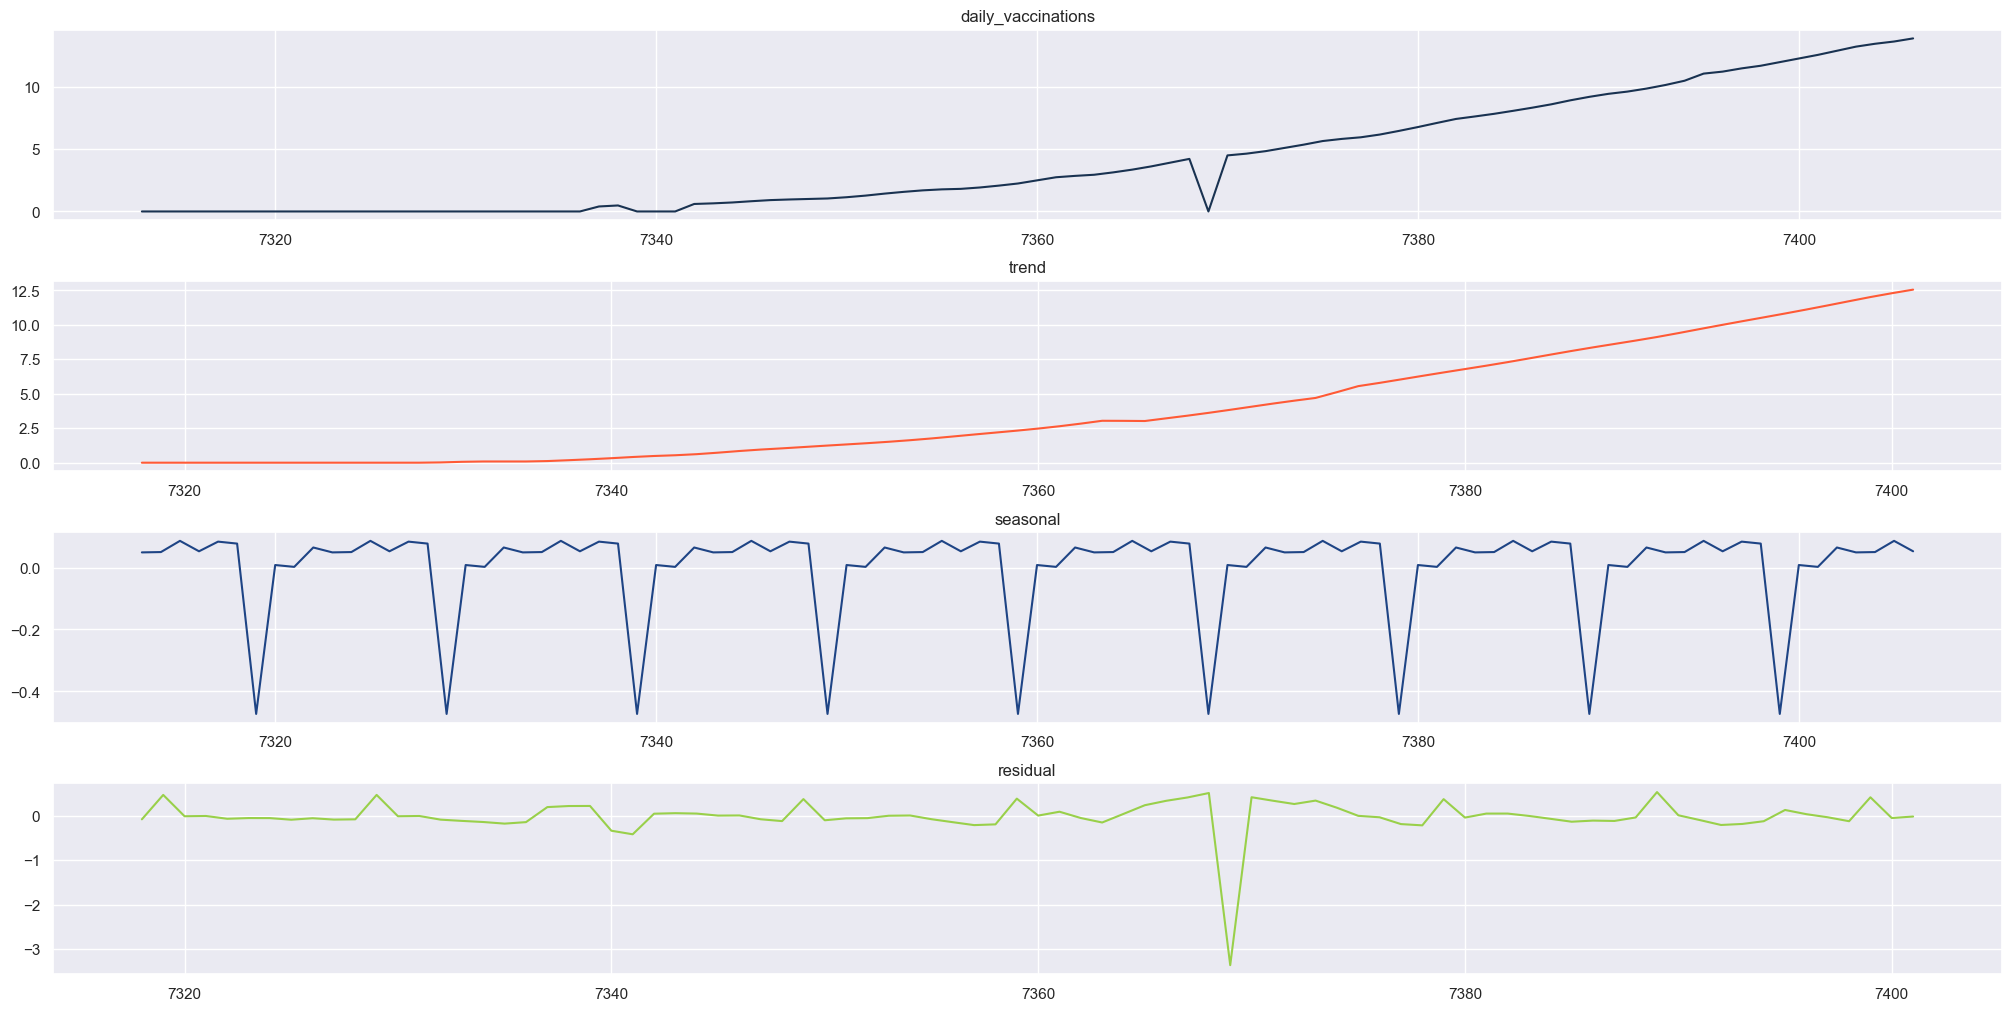

In [23]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time_us['people_fully_vaccinated_per_hundred'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

## De-trend the Time Series 

In [24]:
# De-trending the time series
df_time_us['dayvacc_Detrend'] = (df_time_us['daily_vaccinations'] - df_time_us['daily_vaccinations'].shift(30))

<ipython-input-24-150a28ed87ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_us['dayvacc_Detrend'] = (df_time_us['daily_vaccinations'] - df_time_us['daily_vaccinations'].shift(30))


/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -1.503426
p-value: 0.531816
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.193820
p-value: 0.100000
----------------------------------------


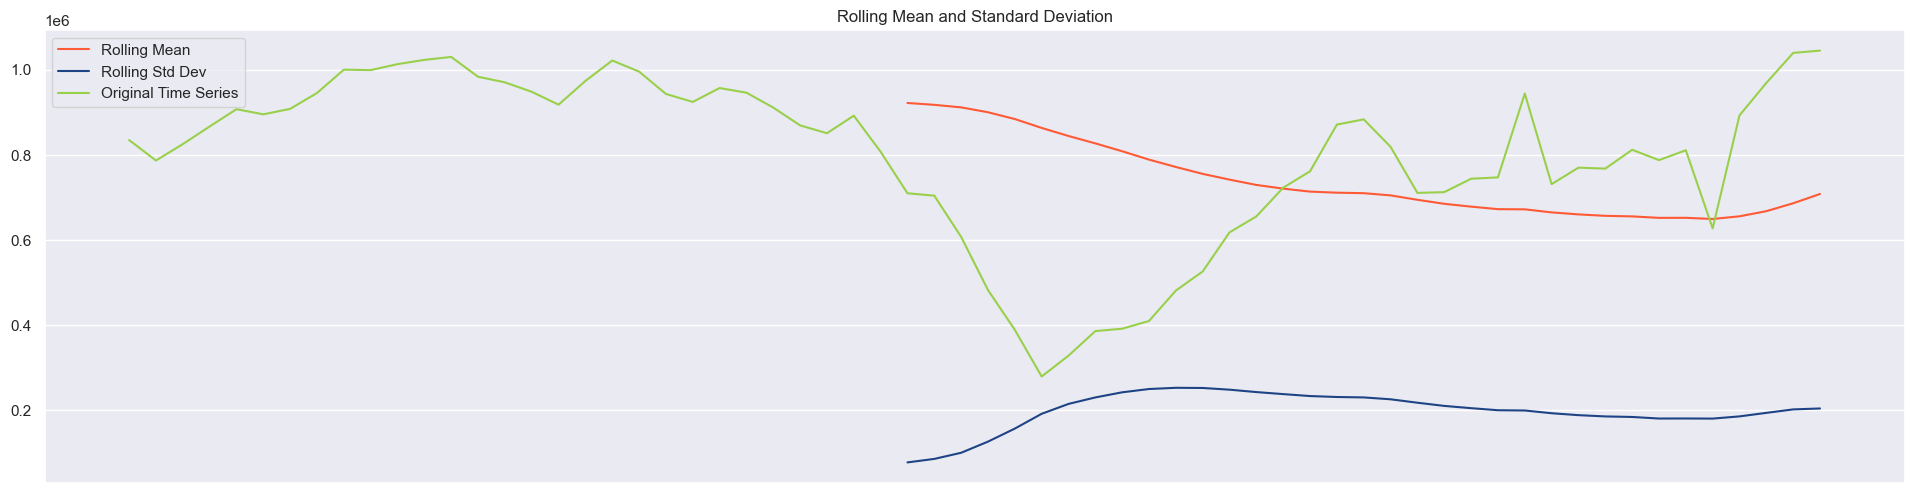

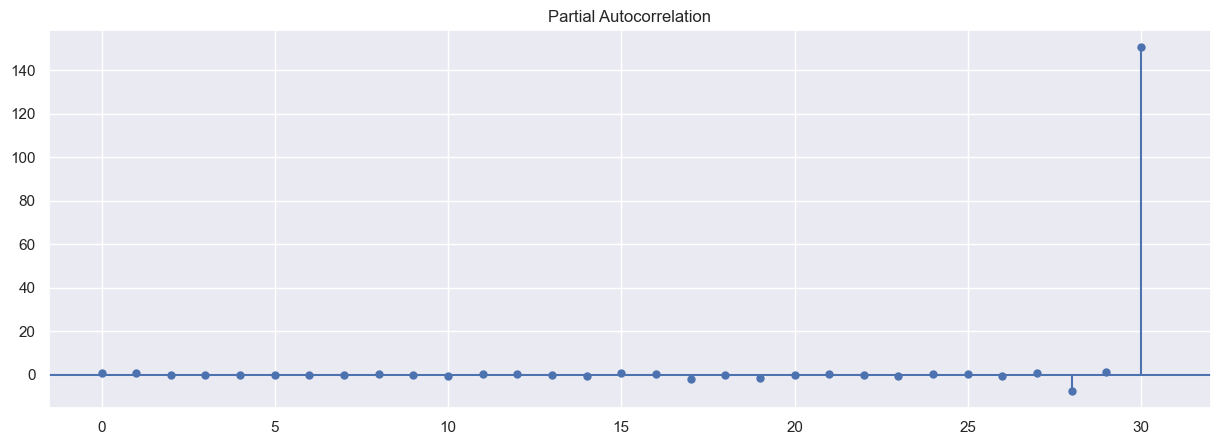

In [25]:
# Test for stationarity after de-trending 
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time_us['dayvacc_Detrend'].dropna())

# Partial Autocorrelation Plot
pacf = plot_pacf(df_time_us['dayvacc_Detrend'].dropna(), lags=30)

In [26]:
# sum up all vaccinations values per day for getting a global value
df_time_index = df_time[['date', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time_index['date'] = pd.to_datetime(df_time_index.date)

df_time_index.set_index('date', inplace=True)
df_time_index.index.get_level_values('date').floor('D')
df_time_index = df_time_index.groupby('date').sum().reset_index()
df_time_index.to_csv('dates_aggregated.csv', encoding='utf-8', index=True)

<ipython-input-26-8bd57623cdb0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_index['date'] = pd.to_datetime(df_time_index.date)


In [27]:
df_time_index

,date,daily_vaccinations,people_fully_vaccinated_per_hundred
0,2020-12-14,84117.0,0.00
1,2020-12-15,84835.0,0.00
2,2020-12-16,276483.0,0.00
3,2020-12-17,277373.0,0.00
4,2020-12-18,277766.0,0.00
...,...,...,...
96,2021-03-20,10403821.0,297.16
97,2021-03-21,10965246.0,294.59
98,2021-03-22,11439431.0,366.09
99,2021-03-23,11328947.0,352.28


In [28]:
df_time.to_csv('timeseriesformodel.csv', encoding='utf-8', index=False)

In [29]:
#df1_corr.head()

NameError: name 'df1_corr' is not defined

In [30]:
#df_time = df1_corr.copy()
df_time.set_index('date')
df_time = df_time[['date','country', 'daily_vaccinations', 'people_fully_vaccinated_per_hundred']]
df_time.sample(20)

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
1943,2021-02-25,Czechia,14626.0,2.20
394,2021-01-18,Austria,12349.0,0.01
325,2021-03-08,Argentina,71076.0,0.76
6538,2021-03-17,Slovenia,6293.0,4.39
489,2021-02-17,Azerbaijan,9929.0,0.00
493,2021-02-21,Azerbaijan,9929.0,0.00
3125,2021-01-08,Iceland,63.0,0.00
2830,2021-02-23,Greenland,77.0,0.00
3800,2021-01-22,Jordan,2727.0,0.00
173,2021-03-15,Angola,4283.0,0.00


In [31]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

,ID
date,0
country,0
daily_vaccinations,0
people_fully_vaccinated_per_hundred,0


In [32]:
df_time.dropna(axis=0)

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
0,2021-02-23,Afghanistan,1367.0,0.0
1,2021-02-24,Afghanistan,1367.0,0.0
2,2021-02-25,Afghanistan,1367.0,0.0
3,2021-02-26,Afghanistan,1367.0,0.0
4,2021-02-27,Afghanistan,1367.0,0.0
...,...,...,...,...
7492,2021-03-20,Zimbabwe,836.0,0.0
7493,2021-03-21,Zimbabwe,910.0,0.0
7494,2021-03-22,Zimbabwe,805.0,0.0
7495,2021-03-23,Zimbabwe,655.0,0.0


In [33]:
#check for missing values
missing_values = pd.DataFrame(df_time.isnull().sum(), columns=['ID'])
missing_values

,ID
date,0
country,0
daily_vaccinations,0
people_fully_vaccinated_per_hundred,0


In [34]:
df_time.isnull().any()

date                                   False
country                                False
daily_vaccinations                     False
people_fully_vaccinated_per_hundred    False
dtype: bool

In [35]:
df_time.dropna(inplace = True)

In [37]:
#check for missing values in %
round(100*(df_time.isnull().sum()/len(df_time.index)),0)

date                                   0.0
country                                0.0
daily_vaccinations                     0.0
people_fully_vaccinated_per_hundred    0.0
dtype: float64

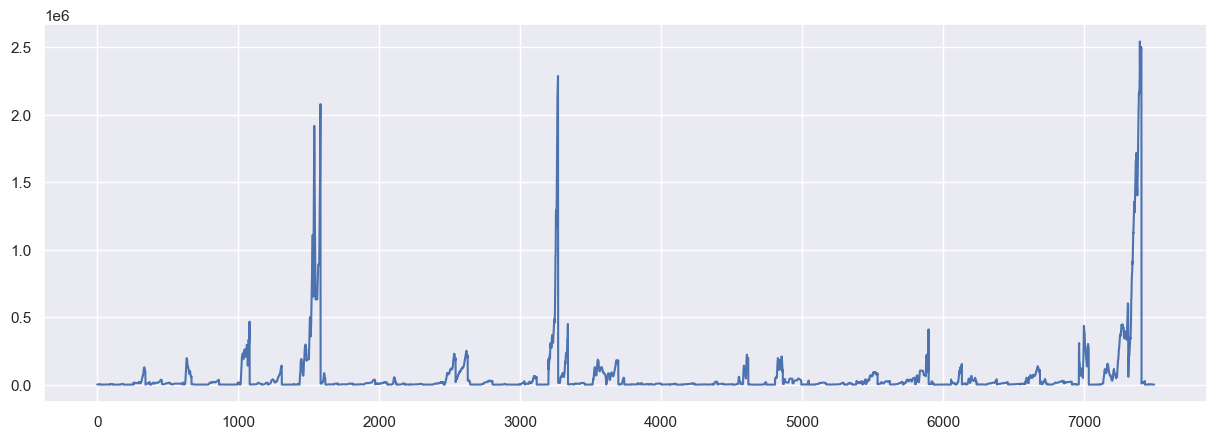

In [38]:
#nicht richtig , siehe Achsenwerte, Problem mehrere Werte pro Tag, da pro Land?
df_time["daily_vaccinations"].plot();

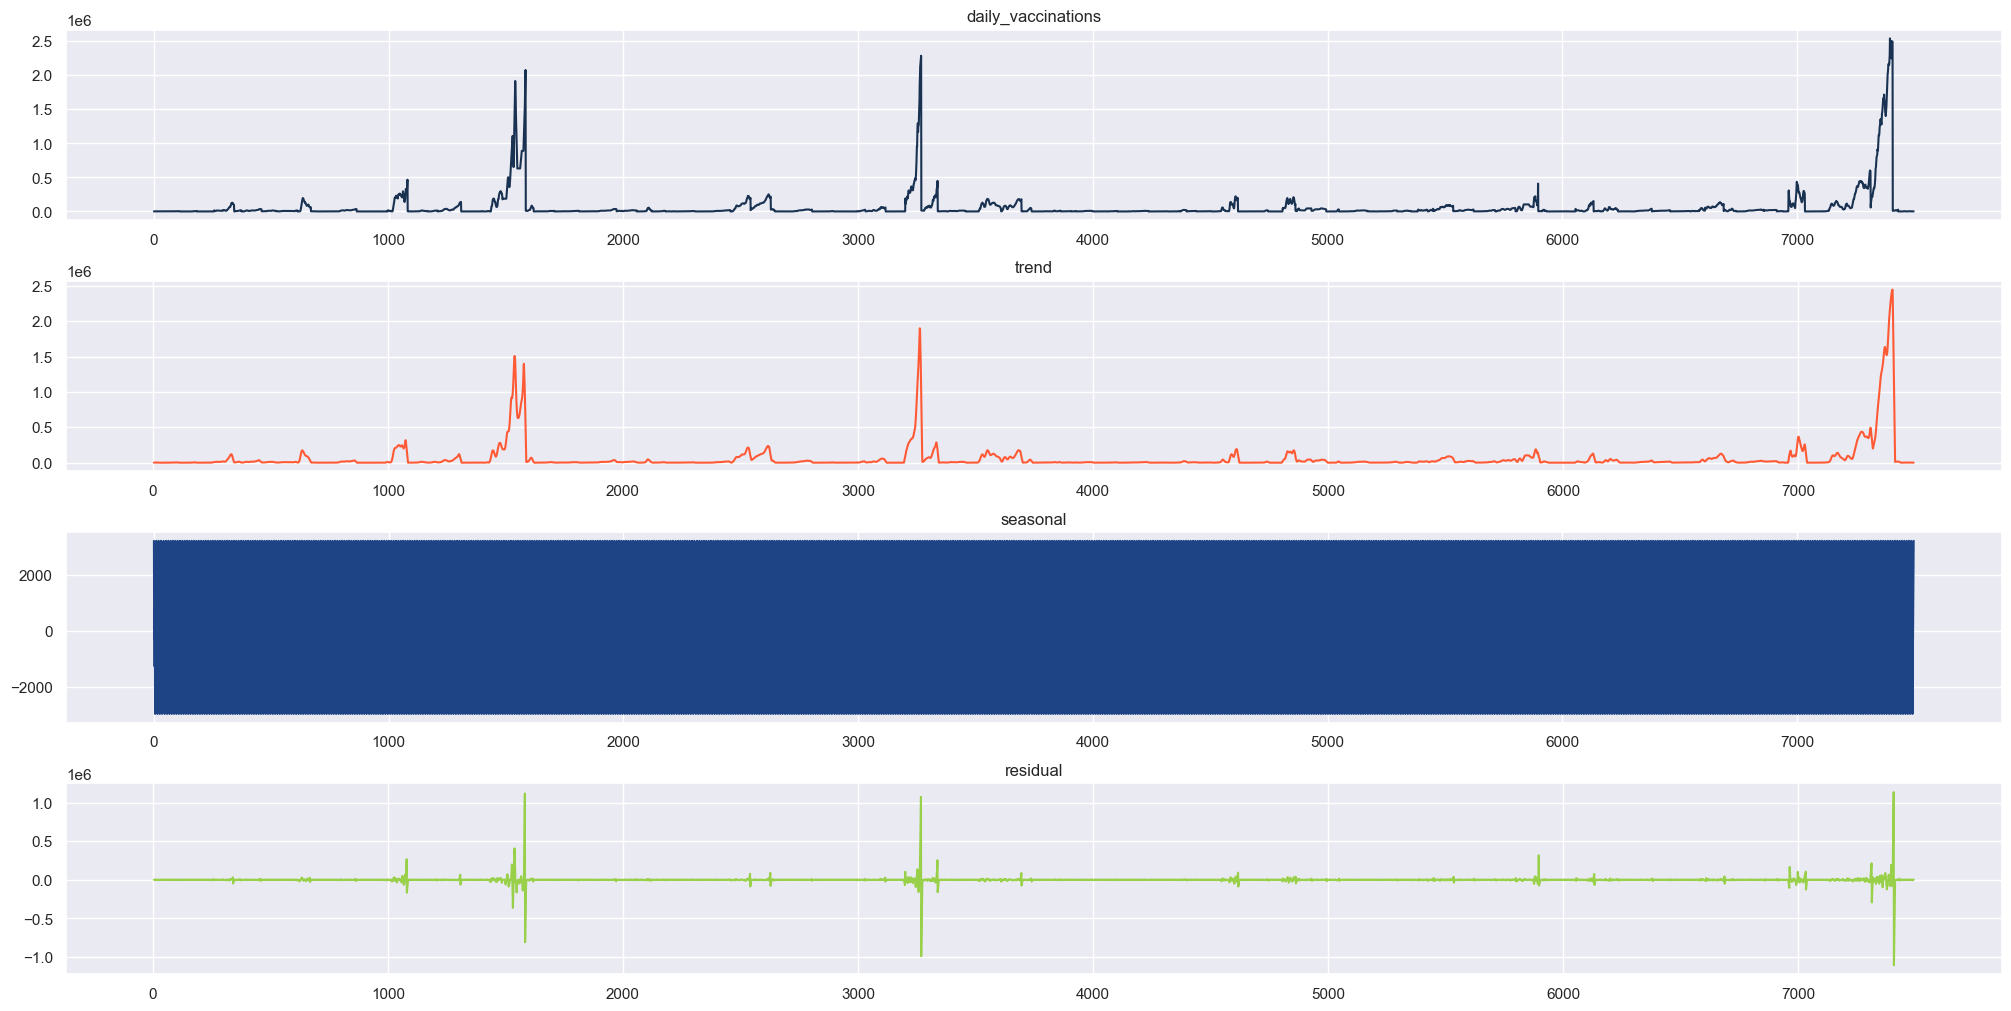

In [39]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time['daily_vaccinations'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

xxx

## Check for Stationarity

Stationarity: A time series is stationary if its statistical properties (e.g. mean, variance, etc.) are the same throughout the series, independently of the point in time where you observe it. There are no long-term predictable patterns such as trend or seasonality. Plots will show a roughly horizontal trend with constant variance.

noch umschreiben:

In order to check for stationarity we will apply three different methods. First, we will calculate and plot the rolling mean and rolling standard deviation. It they show an upward or downward trend or vary over time, then it is highly likely that our time series is non-stationary. Furthermore, we will use the ADF (Augmented Dickey-Fuller) and the KPSS (Kwiatkowski-Phillips-Schmidt-Shintests) tests. We have to be careful when interpreting the results: the null-hypothesis of the ADF test is that the time series is non-stationary whereas the KPSS test assumes that it is stationary.

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -7.949467
p-value: 0.000000
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.473625
p-value: 0.047607
----------------------------------------


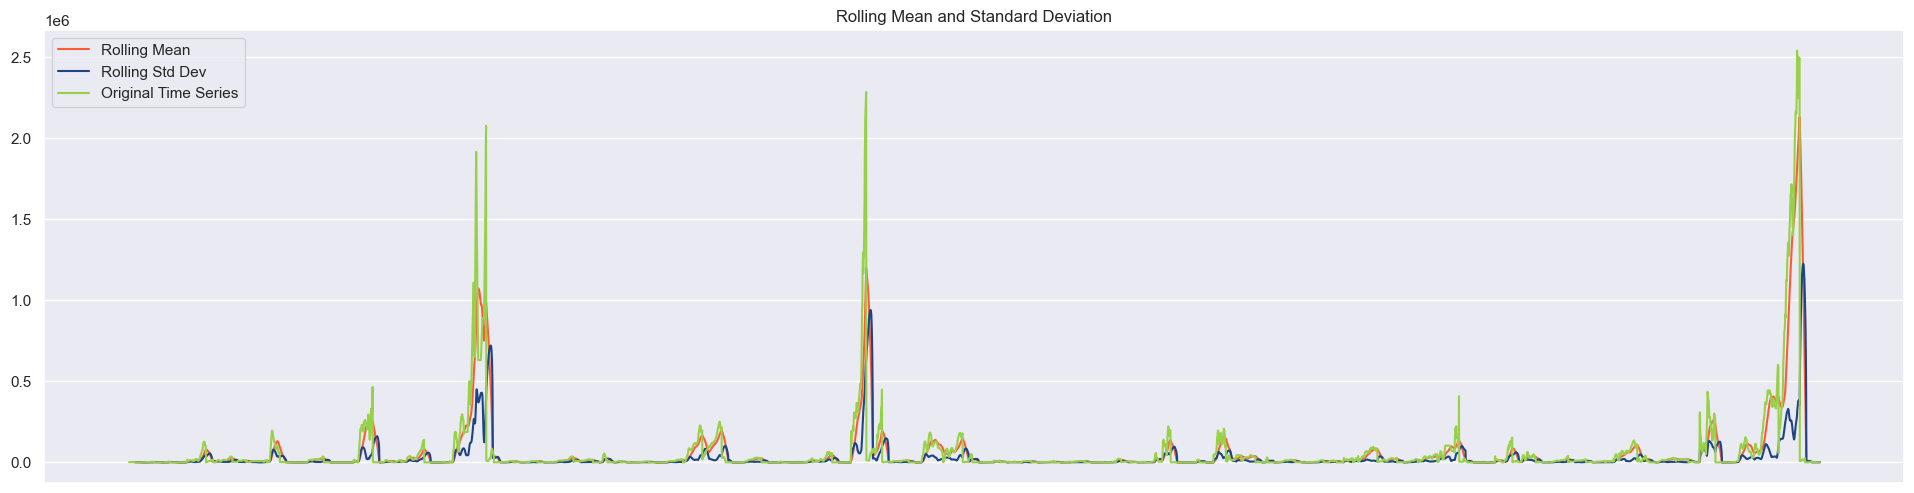

In [40]:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time['daily_vaccinations'])

The rolling mean moves up and down over time as as the daily vaccinations vary. The p-value of the ADF test is 0 which tells us that we can decline the null-hypothesis that the time series is non-stationary and the p-value for the KPSS test is over 0.05 which means we cannot reject this null-hypothesis that it is stationary. Both tests indicates that it is stationary.

In [41]:
#check for stationarity for country data:
df_time_us = df_time[df_time.country == 'United States']
df_time_us

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
7313,2020-12-21,United States,57909.0,0.00
7314,2020-12-22,United States,127432.0,0.00
7315,2020-12-23,United States,150606.0,0.00
7316,2020-12-24,United States,191001.0,0.00
7317,2020-12-25,United States,215238.0,0.00
...,...,...,...,...
7402,2021-03-20,United States,2248285.0,12.87
7403,2021-03-21,United States,2488734.0,13.20
7404,2021-03-22,United States,2489697.0,13.43
7405,2021-03-23,United States,2497025.0,13.61


In [42]:
#check for missing values in %
round(100*(df_time_us.isnull().sum()/len(df_time_us.index)),0)

date                                   0.0
country                                0.0
daily_vaccinations                     0.0
people_fully_vaccinated_per_hundred    0.0
dtype: float64

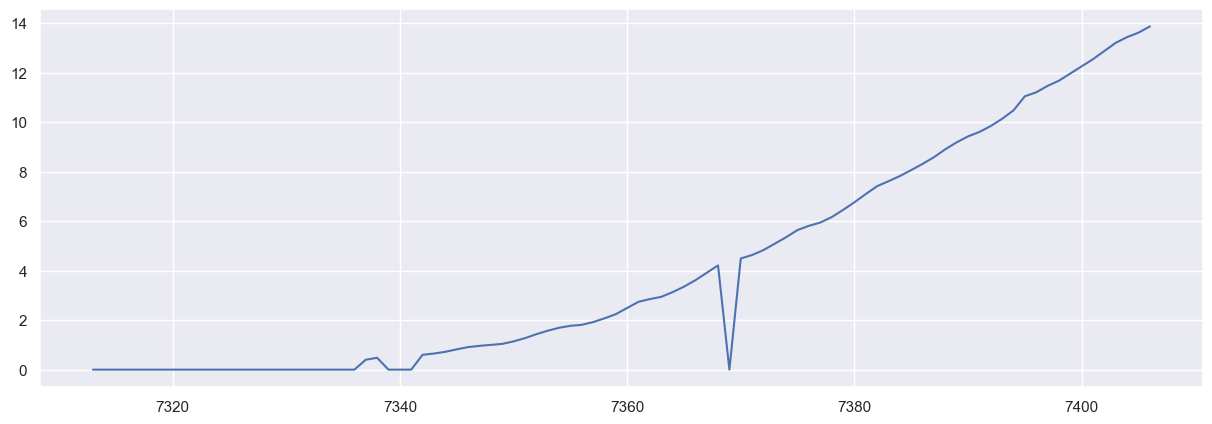

In [43]:

df_time_us["people_fully_vaccinated_per_hundred"].plot();

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -0.520049
p-value: 0.888044
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.815044
p-value: 0.010000
----------------------------------------


/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


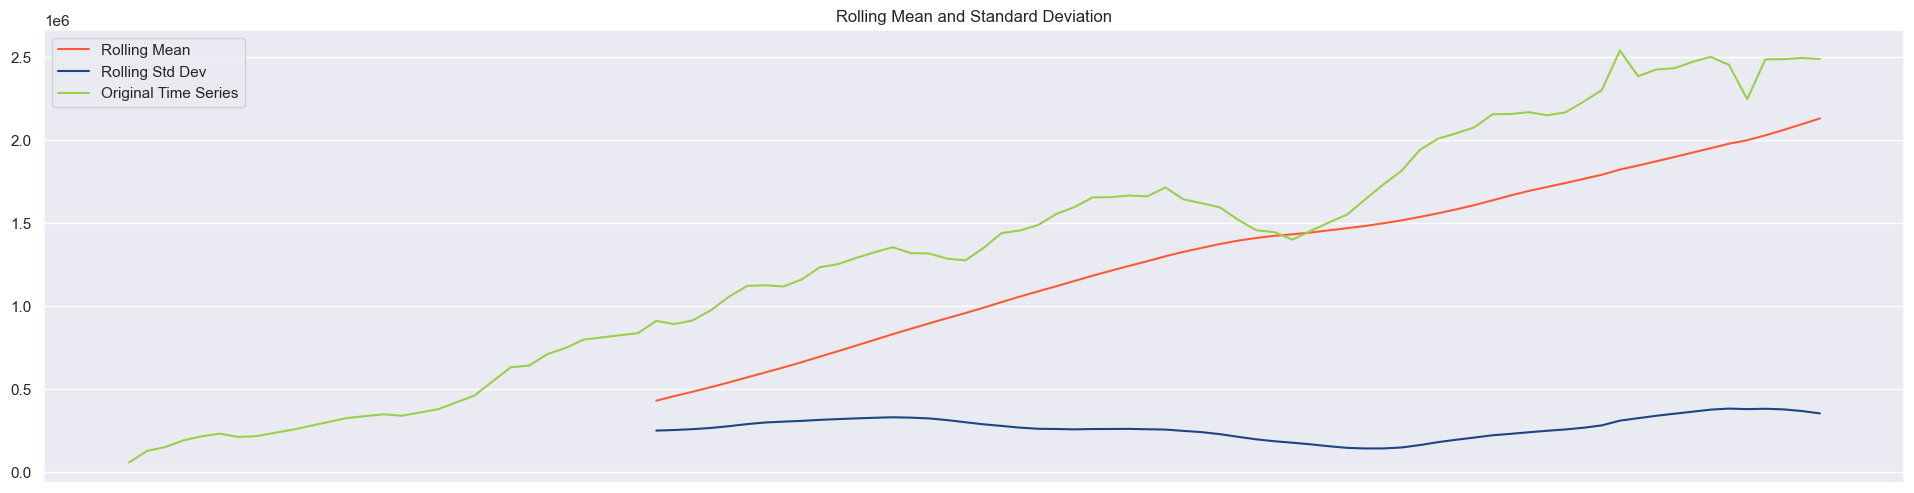

In [44]:
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time_us['daily_vaccinations'])

The p-value of the ADF test is > 0.5 which tells us that we cannot decline the null-hypothesis that the time series is non-stationary and the p-value for the KPSS test is below 0.05 which means we can reject this null-hypothesis that it is stationary. Both tests indicates that it is not stationary.

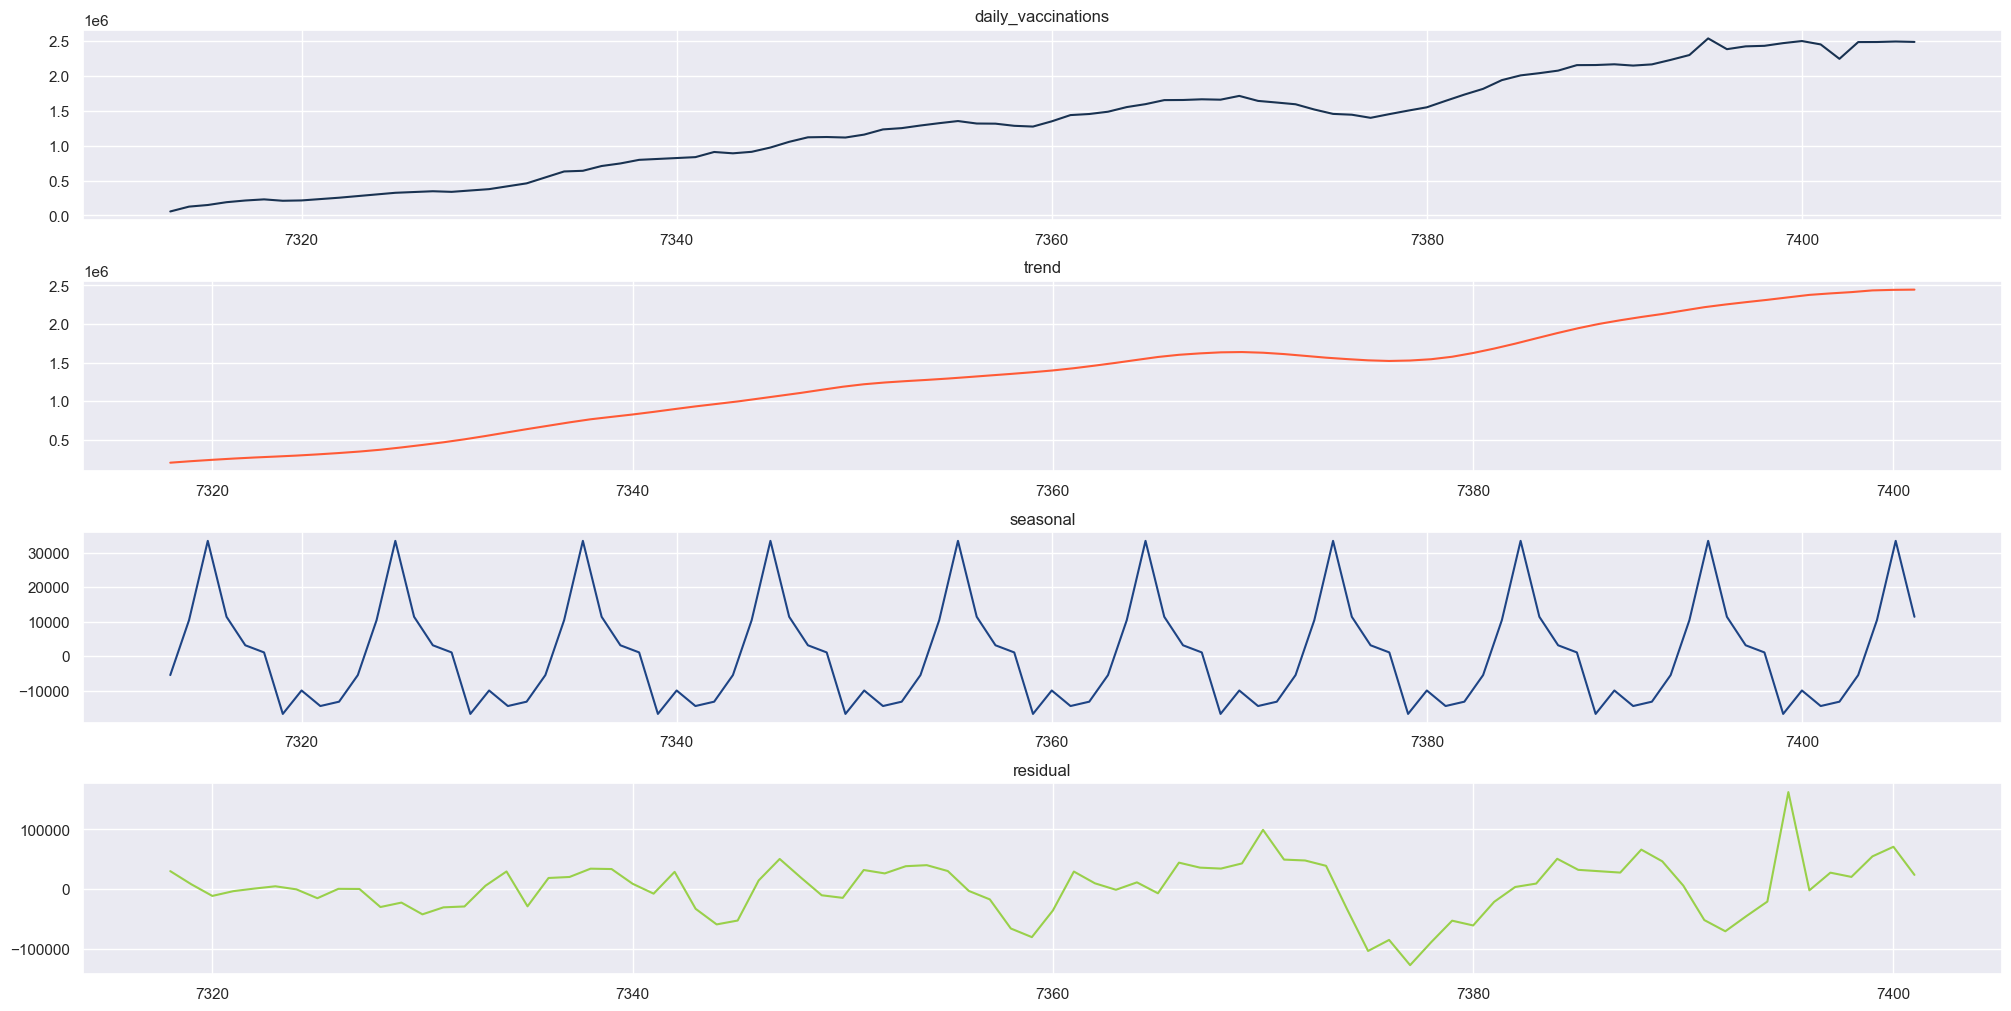

In [45]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time_us['daily_vaccinations'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

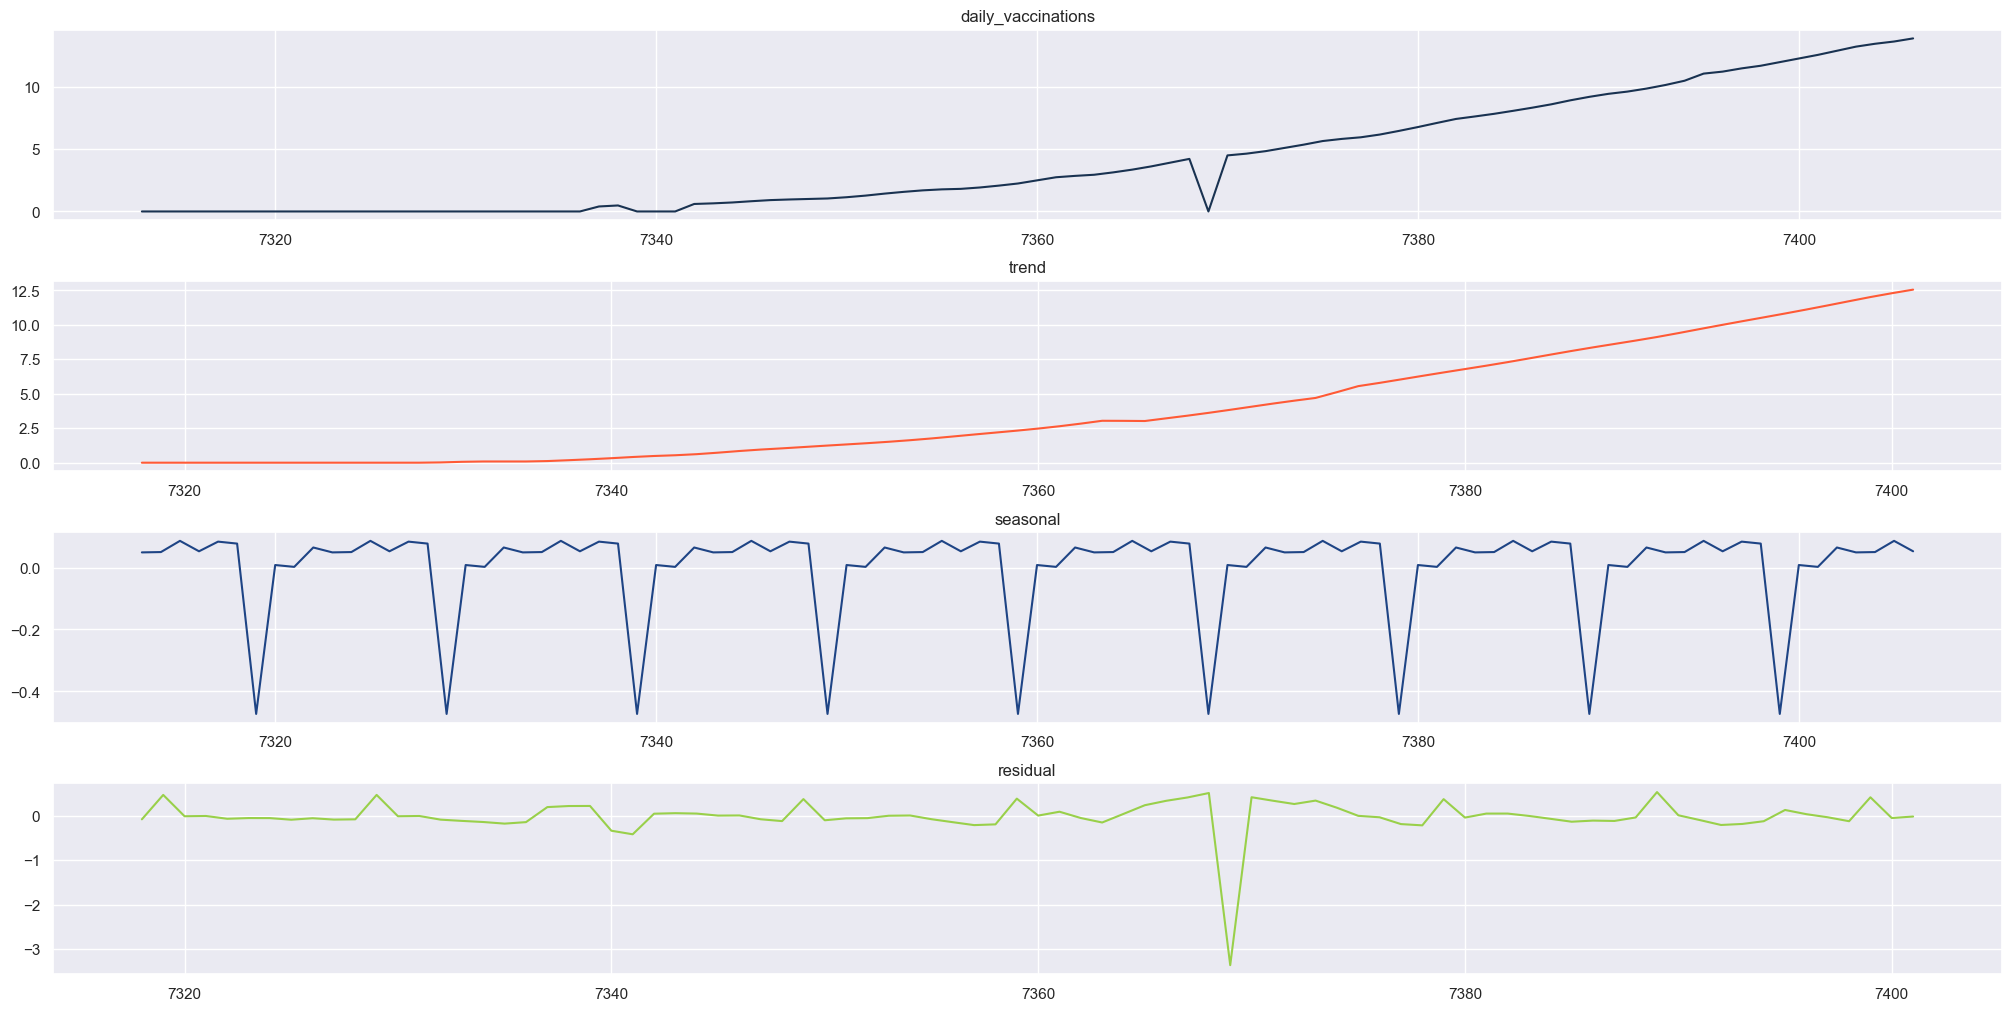

In [46]:
# Check decomposition of trend, seasonality and residue of original time series

decomposition = seasonal_decompose(x=df_time_us['people_fully_vaccinated_per_hundred'], period=10)# model='multiplicative',

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='daily_vaccinations')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

## De-trend the Time Series 

In [47]:
# De-trending the time series
df_time_us['dayvacc_Detrend'] = (df_time_us['daily_vaccinations'] - df_time_us['daily_vaccinations'].shift(30))

<ipython-input-47-150a28ed87ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_us['dayvacc_Detrend'] = (df_time_us['daily_vaccinations'] - df_time_us['daily_vaccinations'].shift(30))


/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -1.503426
p-value: 0.531816
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.193820
p-value: 0.100000
----------------------------------------


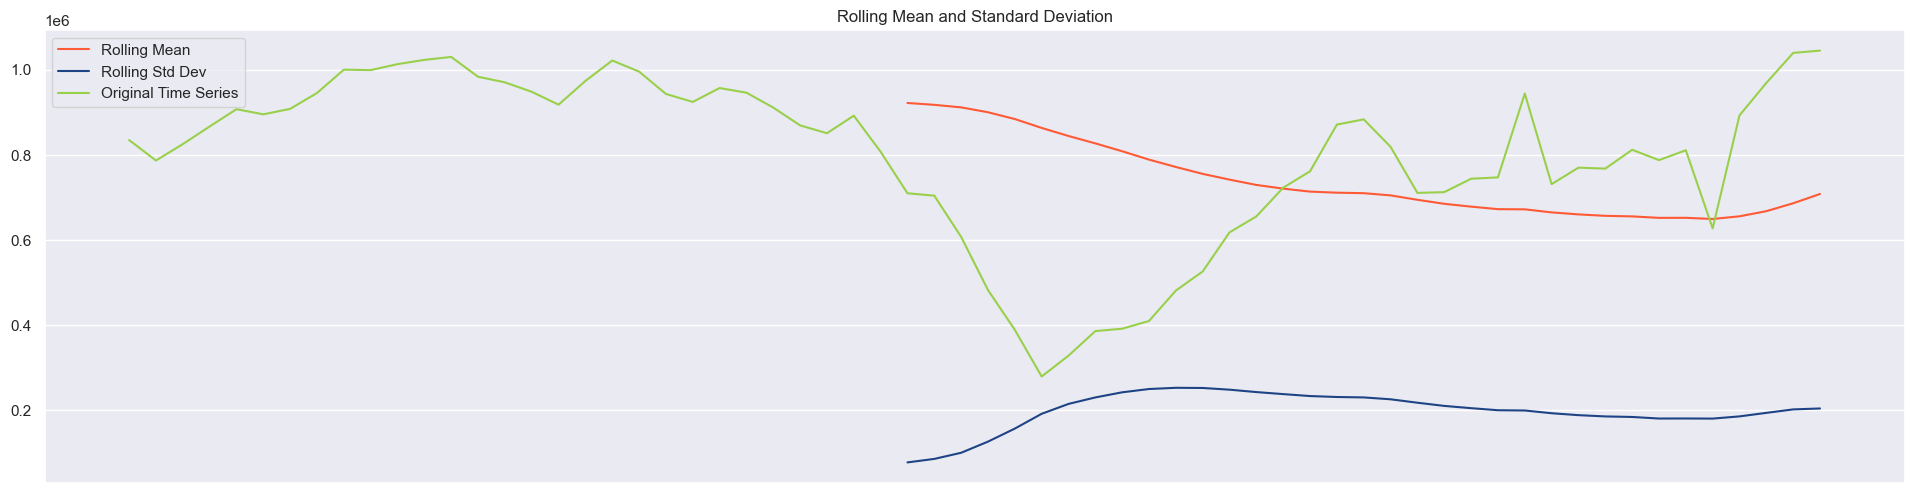

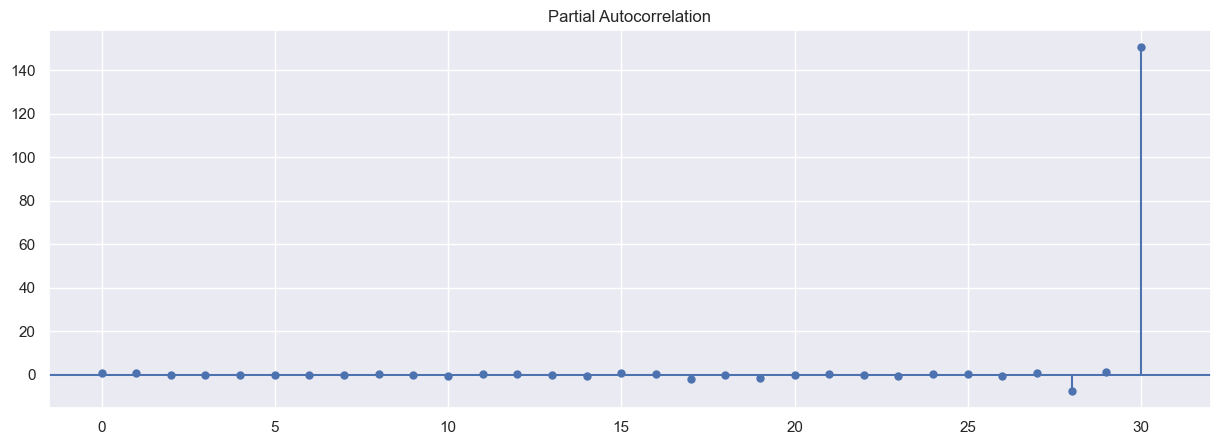

In [48]:
# Test for stationarity after de-trending 
def stationarity_test(daily_vaccinations):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = daily_vaccinations.rolling(30).mean()
    rolling_std_dev = daily_vaccinations.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(daily_vaccinations, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(daily_vaccinations,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(daily_vaccinations, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df_time_us['dayvacc_Detrend'].dropna())

# Partial Autocorrelation Plot
pacf = plot_pacf(df_time_us['dayvacc_Detrend'].dropna(), lags=30)

# Benchmark Forecasting

#### Naive Forecast/Persistence algorithm

As baseline method we use the persistence algorithm. It uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1).


In [49]:
df_time_m.head()

,date,country,daily_vaccinations,people_fully_vaccinated_per_hundred
0,2021-02-23,Afghanistan,1367.0,0.0
1,2021-02-24,Afghanistan,1367.0,0.0
2,2021-02-25,Afghanistan,1367.0,0.0
3,2021-02-26,Afghanistan,1367.0,0.0
4,2021-02-27,Afghanistan,1367.0,0.0


In [50]:
df_time_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7891 entries, 0 to 7890
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   date                                 7891 non-null   object 
 1   country                              7891 non-null   object 
 2   daily_vaccinations                   7891 non-null   float64
 3   people_fully_vaccinated_per_hundred  7891 non-null   float64
dtypes: float64(2), object(2)
memory usage: 246.7+ KB


In [51]:
df_time_m['date']=df_time_m['date'].astype('datetime64[ns]')

#

In [52]:
df_time_m['date']= pd.to_datetime(df_time_m['date'])
df_time_wo_detrend = df_time_m[['date','daily_vaccinations']]
df_time_wo_detrend.set_index('date', inplace = True)
df_time_wo_detrend.to_csv('df_time_wo_detrend.csv', encoding='utf-8', index=False)

In [53]:
# Create lagged dataset
#dataframe = pd.concat([df_time_wo_detrend['daily_vaccinations'].shift(periods = 1)], axis =1)
#values = series.values
#dataframe = pd.concat([values.shift(1), values], axis=1)
#dataframe.columns = ['t-1', 't+1']
#print(dataframe.head(5))

In [54]:
# Create lagged dataset
df_time_wo_detrend = df_time_m[['daily_vaccinations']]
df_lagged = df_time_wo_detrend.copy()
trailing_window_size = 1

for window in range(1, trailing_window_size + 1):
    shifted = df_time_wo_detrend.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in df_time_wo_detrend.columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis=1)
df_lagged = df_lagged.dropna()
df_lagged.head(10)

,daily_vaccinations,daily_vaccinations_lag1
1,1367.0,1367.0
2,1367.0,1367.0
3,1367.0,1367.0
4,1367.0,1367.0
5,1367.0,1367.0
6,1580.0,1367.0
7,1794.0,1580.0
8,2008.0,1794.0
9,2221.0,2008.0
10,2435.0,2221.0


Test MSE: 2753869445.233


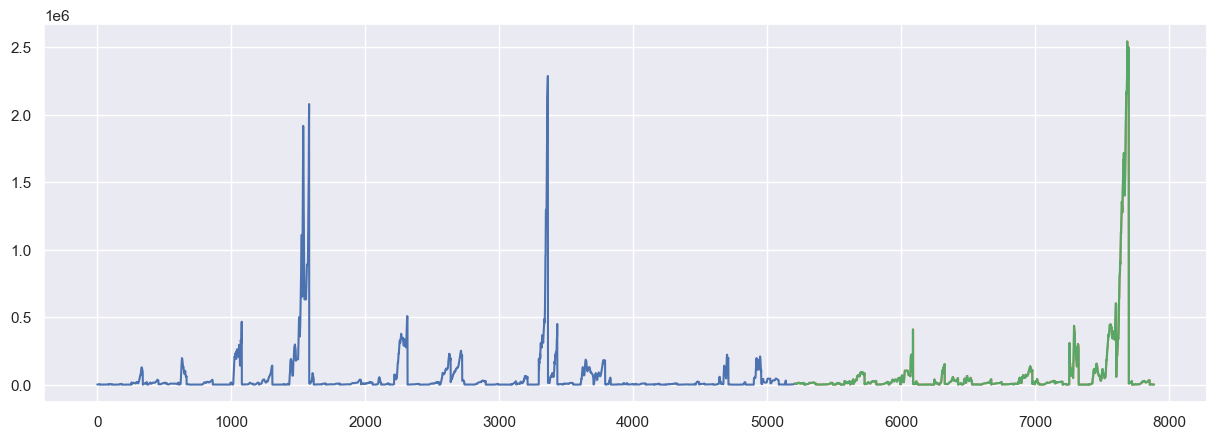

In [55]:
# split into train and test sets
X = df_lagged.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    y_pred = model_persistence(x)
    predictions.append(y_pred)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

geht das überhaupt über alle Länder? Sind doch eigentlich eine Zeitreihe pro Land und damit einzeln zu betrachten, oder?

In [56]:
#Baseline model for United states data only:
baseline_us = df_time_m[df_time_m.country == 'United States']
baseline_us = baseline_us[['date', 'daily_vaccinations']]
baseline_us.head()


#plt.plot(baseline_us['daily_vaccinations'])
#plt.show();

,date,daily_vaccinations
7607,2020-12-21,57909.0
7608,2020-12-22,127432.0
7609,2020-12-23,150606.0
7610,2020-12-24,191001.0
7611,2020-12-25,215238.0


#### Define the Supervised Learning Problem

The first step is to load the dataset and create a lagged representation. That is, given the observation at t-1, predict the observation at t+1.

In [57]:
# Create lagged dataset
df_time_wo_detrend_us = baseline_us[['daily_vaccinations']]
df_lagged_us = df_time_wo_detrend_us.copy()
trailing_window_size = 1

for window in range(1, trailing_window_size + 1):
    shifted = df_time_wo_detrend_us.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in df_time_wo_detrend_us.columns]
    
    df_lagged_us = pd.concat((df_lagged_us, shifted), axis=1)
df_lagged_us = df_lagged_us.dropna()
df_lagged_us.head(10)

,daily_vaccinations,daily_vaccinations_lag1
7608,127432.0,57909.0
7609,150606.0,127432.0
7610,191001.0,150606.0
7611,215238.0,191001.0
7612,231396.0,215238.0
7613,211379.0,231396.0
7614,216147.0,211379.0
7615,235685.0,216147.0
7616,255223.0,235685.0
7617,278776.0,255223.0


Test MSE: 8246182421.094


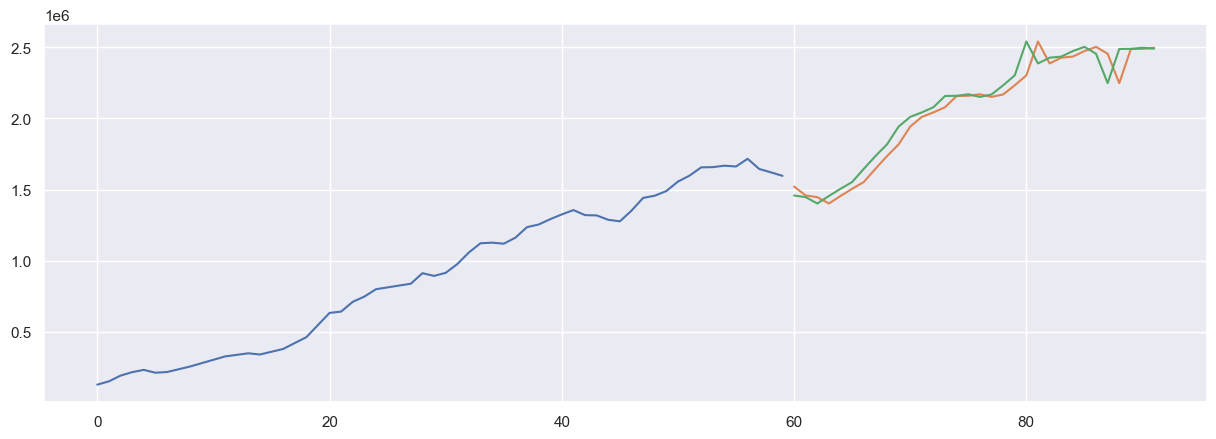

In [58]:
# split into train and test sets
X = df_lagged_us.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    y_pred = model_persistence(x)
    predictions.append(y_pred)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()
# label einfügen!

green line = test data
orange line = prediction

The plot shows the trainings dataset and the diverging predictions from the expected values from the test dataset.

It shows ???
(?The plot shows that the model is 1-step behind reality.?)



### Models for predicting vaccinations progress United States

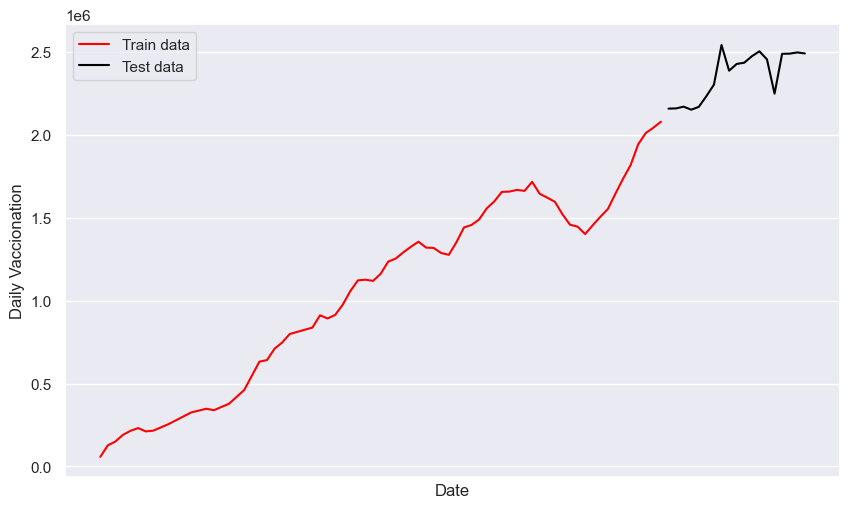

In [59]:
# Split data into train and test set
df_time_m_us = df_time_m[df_time_m.country == 'United States']
df_time_m_us = df_time_m_us[['daily_vaccinations']]
df_arima = df_time_m_us['daily_vaccinations']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Daily Vaccionation')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

## Simple Exponential Smoothing

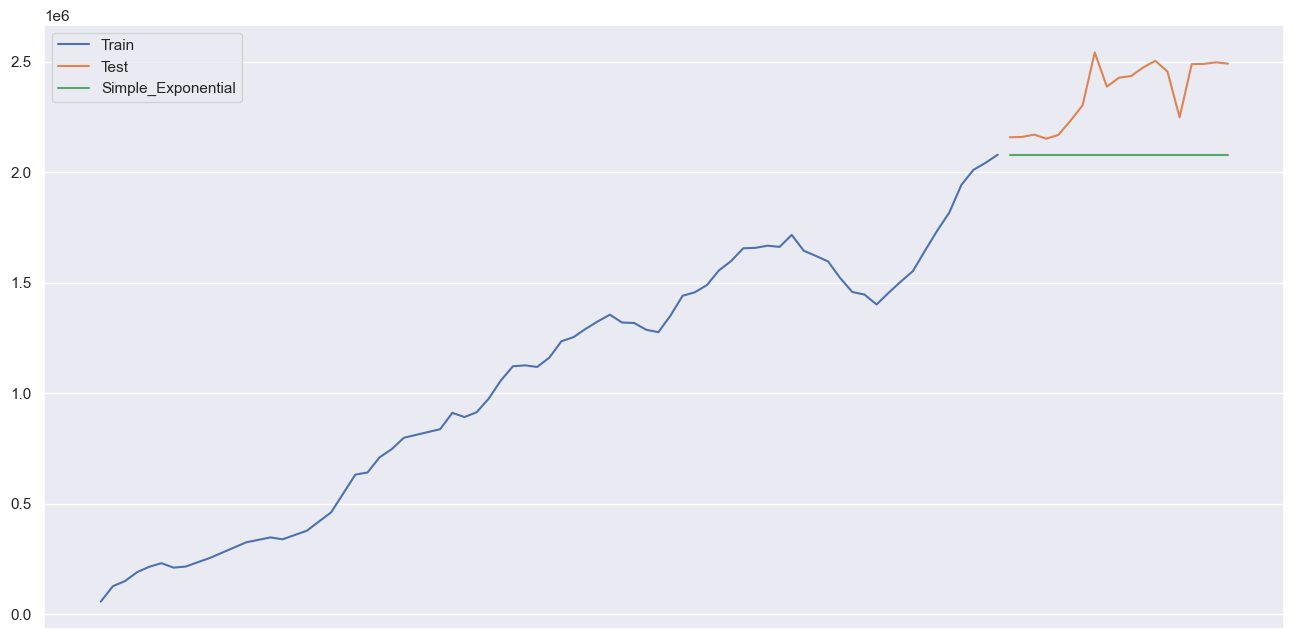

Simple Exponential Smoothing RMS :- 312111.348 & Smoothing Level :- 1.0


In [60]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

## Holt's Exponential Smoothing

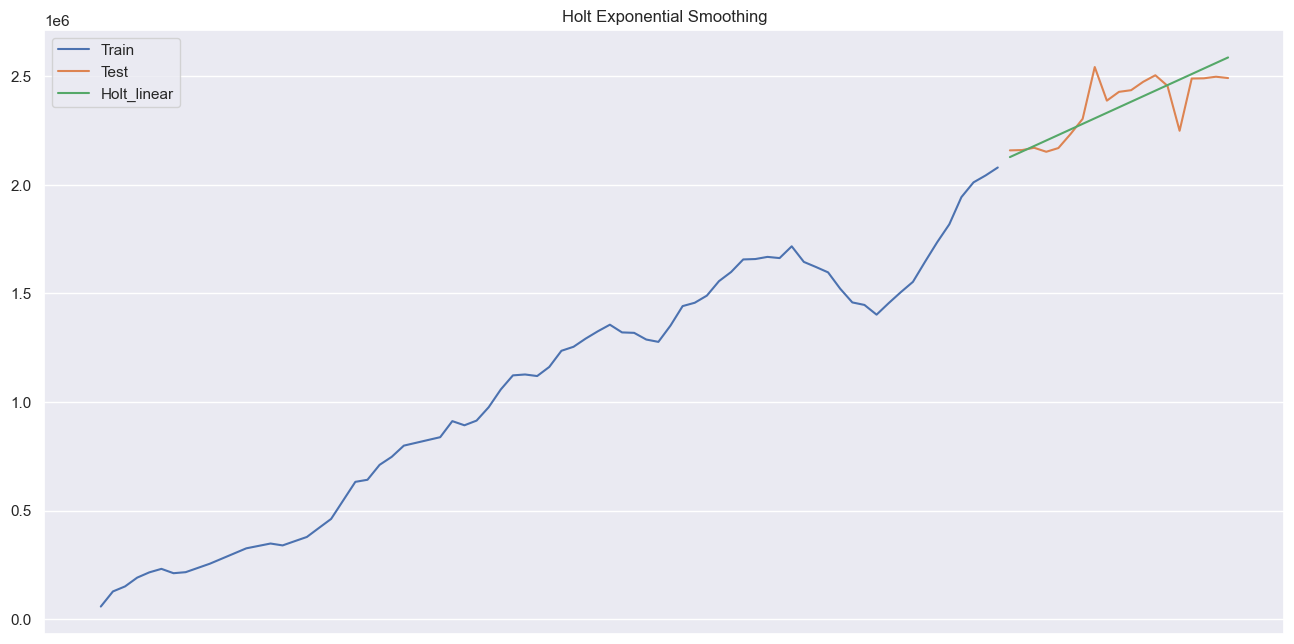

Holt’s Exponential Smoothing RMS :- 90480.675 & Smoothing Level :- 0.55 & Smoothing Slope :- 1.0


In [61]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
    holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

## Auto-Regressive Integrated Moving Average (ARIMA)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1832.499, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2205.294, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1854.871, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2149.893, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2313.826, Time=0.00 sec


/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1809.395, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1810.711, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1808.797, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1807.037, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1806.820, Time=0.10 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=1809.149, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 1.155 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   75
Model:               SARIMAX(4, 0, 0)   Log Likelihood                -897.410
Date:                Thu, 22 Apr 2021   AIC                           1806.820
Time:                       

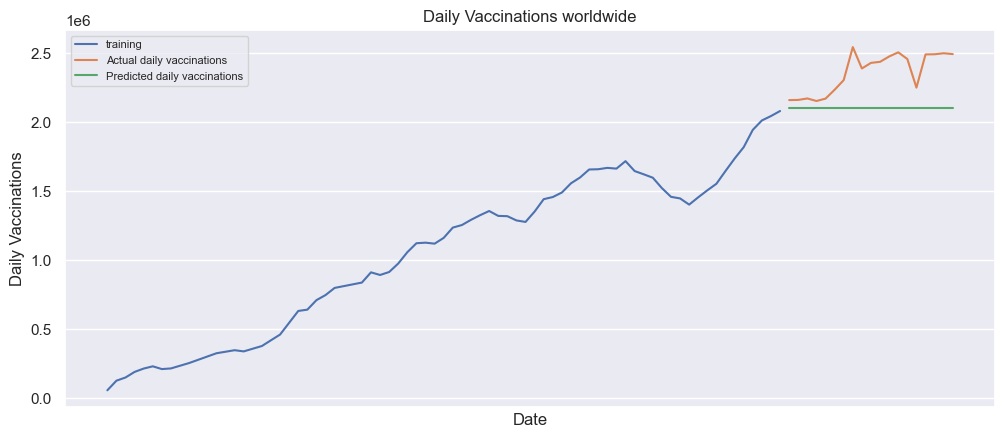

Auto-Arima RMSE :- 289969.341


In [62]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False,
                      stationary = True,
                         n_jobs = -1
                      )#stationar = True ergänzt, n_jobs ergänzt mit -1 

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual daily vaccinations')
plt.plot(fcv_series,label='Predicted daily vaccinations')
plt.title('Daily Vaccinations worldwide')
plt.xlabel('Date')
plt.ylabel('Daily Vaccinations')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

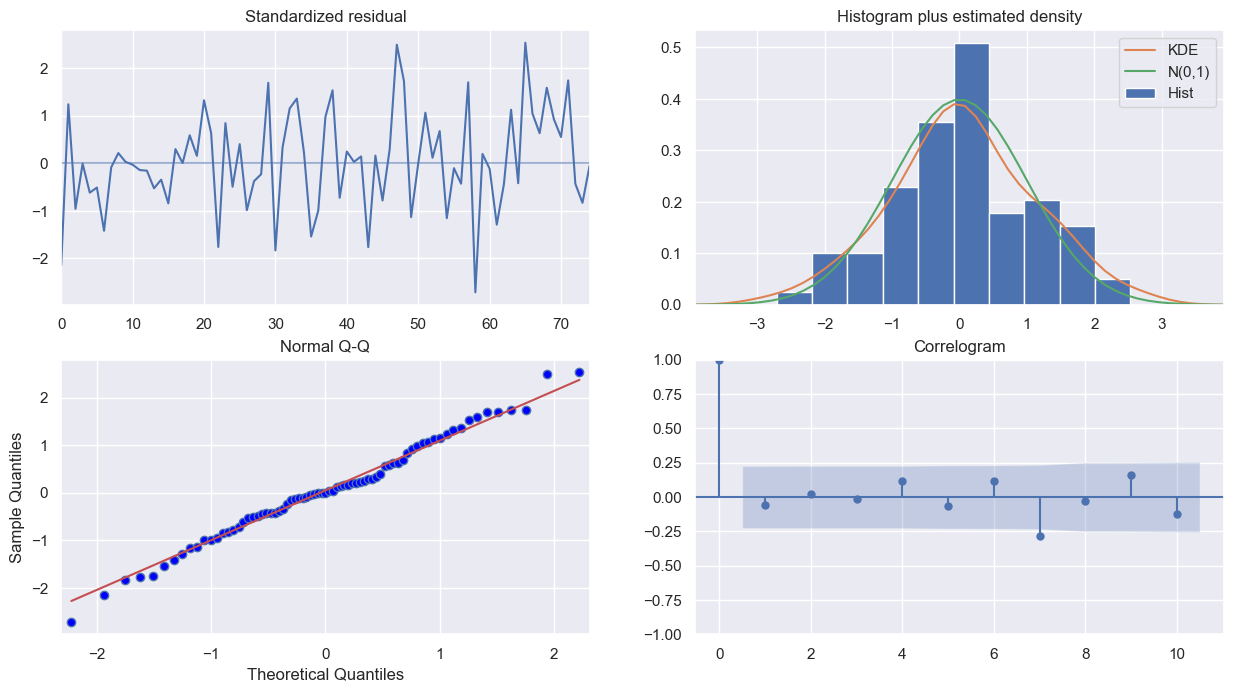

In [63]:
# Plotting diagnostics of the ARIMA model
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

In [64]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

RMSE of all the methods
Auto-Arima:  289969.341
Simple Exponential Smoothing:  312111.348
Holt’s Exponential Smoothing:  90480.675


From the three models we trained the Holt's Exponential Smoothing reached the smallest RSME but all models are not really satisfying.

### Models for predicting vaccinations progress worldwide

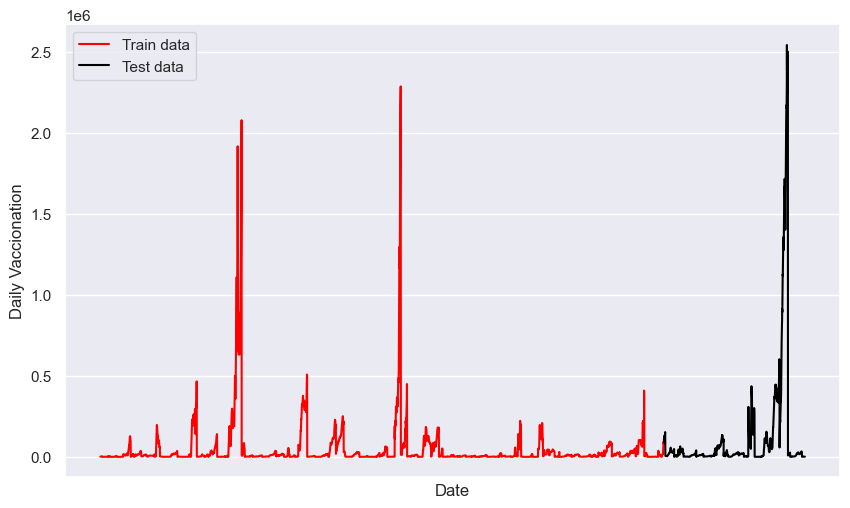

In [65]:
# Split data into train and test set
df_arima = df_time_m['daily_vaccinations']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Daily Vaccionation')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

## Simple Exponential Smoothing

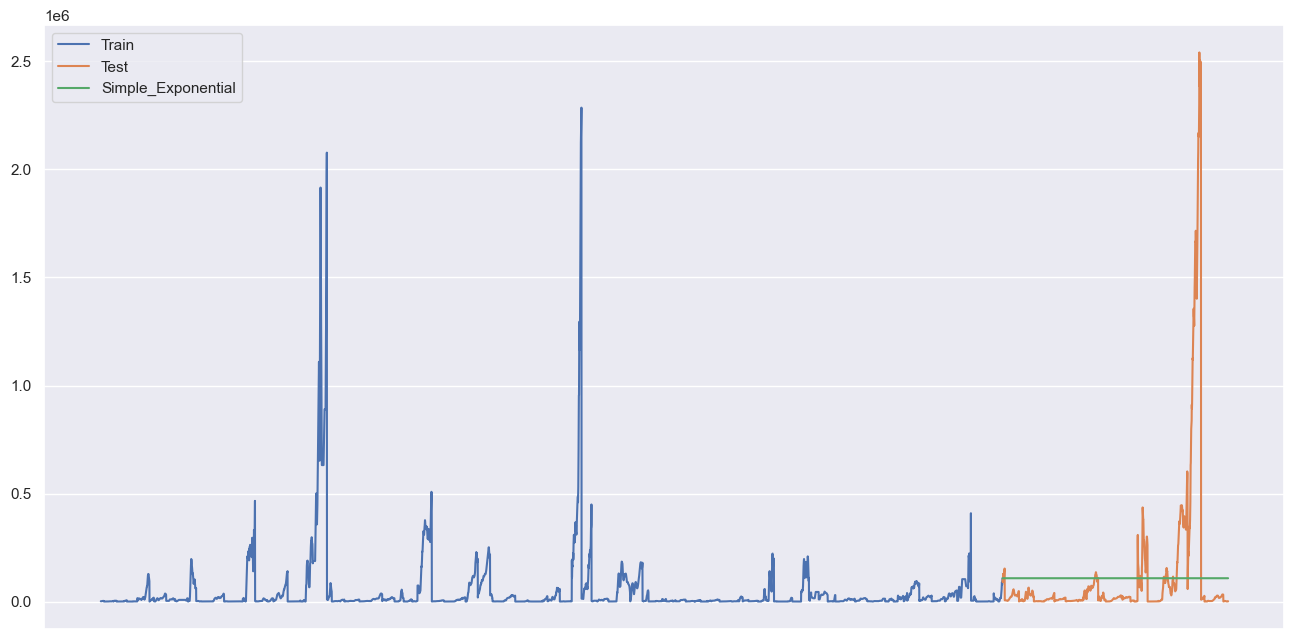

Simple Exponential Smoothing RMS :- 360897.876 & Smoothing Level :- 1.0


In [66]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

## Holt's Exponential Smoothing

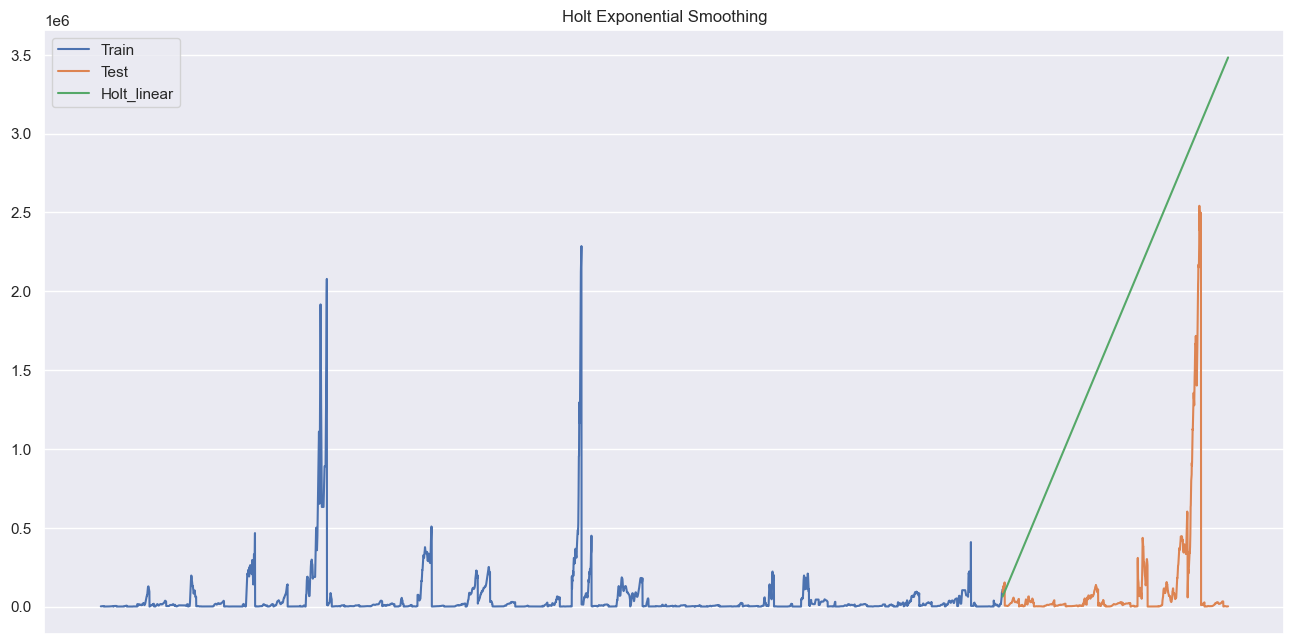

Holt’s Exponential Smoothing RMS :- 1896151.206 & Smoothing Level :- 0.1 & Smoothing Slope :- 0.05


In [67]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
    holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

## Auto-Regressive Integrated Moving Average (ARIMA)

Performing stepwise search to minimize aic


/Users/birte/neuefische1/Capstone_Covid/.venv/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=152545.450, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=168636.202, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=152555.821, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=164338.655, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=169163.906, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=152543.130, Time=1.87 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=152544.426, Time=0.32 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=152539.765, Time=0.53 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=152537.321, Time=0.32 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=152539.294, Time=0.47 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=152541.639, Time=0.98 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=152547.690, Time=0.21 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 5.728 seconds
                               SARIMAX Results                                
Dep. Variable:              

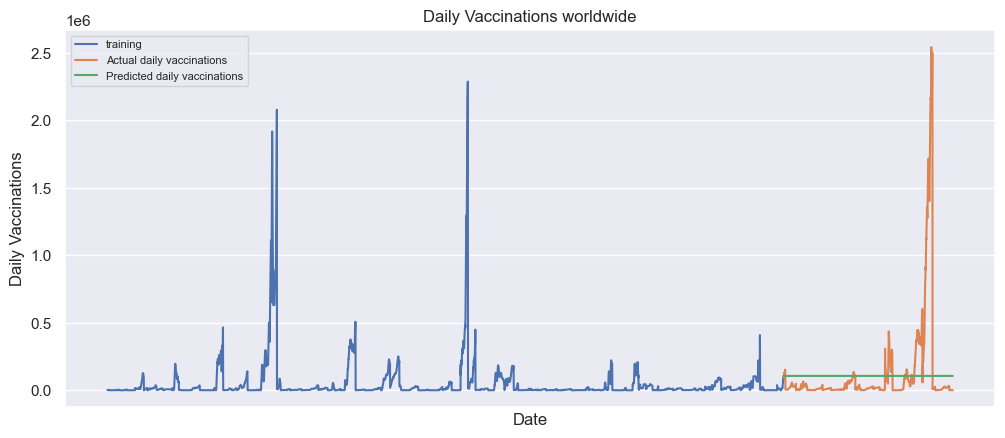

Auto-Arima RMSE :- 360964.969


In [68]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False,
                      stationary = True,
                         n_jobs = -1
                      )#stationar = True ergänzt, n_jobs ergänzt mit -1 

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual daily vaccinations')
plt.plot(fcv_series,label='Predicted daily vaccinations')
plt.title('Daily Vaccinations worldwide')
plt.xlabel('Date')
plt.ylabel('Daily Vaccinations')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

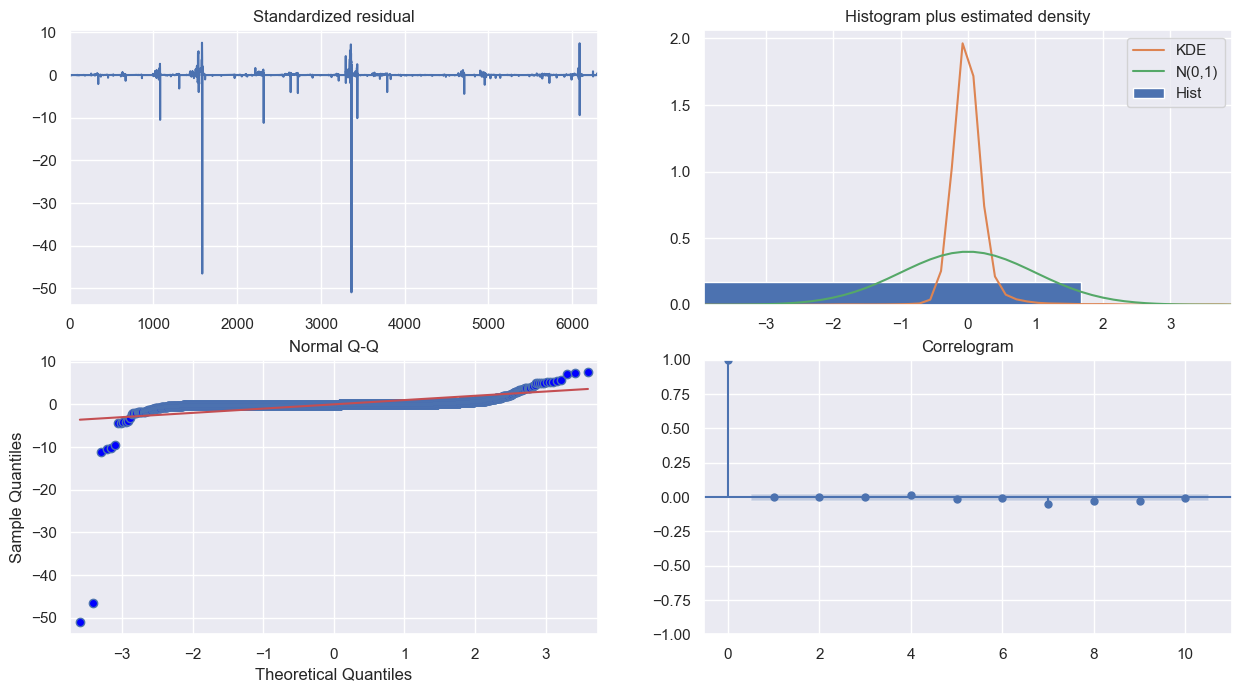

In [69]:
# Plotting diagnostics of the ARIMA model
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

Evaluation of the models
to evaluate the performance of the model, we will use Root Mean Squared Error (RMSE) and compare which model performed the best.

In [70]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

RMSE of all the methods
Auto-Arima:  360964.969
Simple Exponential Smoothing:  360897.876
Holt’s Exponential Smoothing:  1896151.206


From the three models we trained the Simple Exponential Smoothing reached the smallest RSME. (Woran liegt das? Wir haben keinen Trend und keine seasonality und damit z.B. Holt's nicht geeignet?)

## Facebook Prophet

In [71]:
from fbprophet import Prophet

In [72]:
# print version number
#print('Prophet %s' % fbprophet.__version__)

In [73]:
# prepare expected column names
df_fbprophet = df_time_m[['date', 'daily_vaccinations']]
df_fbprophet.columns = ['ds', 'y']
#df_fbprophet.ds = df_fbprophet.ds.astype(int)
#df_fbprophet['ds']= to_datetime(df_fbprophet['ds'])
df_fbprophet["ds"] = pd.to_datetime(df_fbprophet['ds'])#index

<ipython-input-73-a68ba644ac7d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fbprophet["ds"] = pd.to_datetime(df_fbprophet['ds'])#index


In [74]:
#split into train and test set:

train_test_split_ratio = int(len(df_fbprophet)*0.8)
train_data, test_data = df_fbprophet[:train_test_split_ratio], df_fbprophet[train_test_split_ratio:]

In [75]:
test_data

,ds,y
6312,2021-03-10,97513.0
6313,2021-03-11,89971.0
6314,2021-03-12,106051.0
6315,2021-03-13,111996.0
6316,2021-03-14,128481.0
...,...,...
7886,2021-03-20,836.0
7887,2021-03-21,910.0
7888,2021-03-22,805.0
7889,2021-03-23,655.0


In [76]:
model1=Prophet(interval_width=0.95) # by default is 80%
#‘interval_width=0.95’, this sets the uncertainty interval to produce a confidence interval around the forecast.

TypeError: string indices must be integers

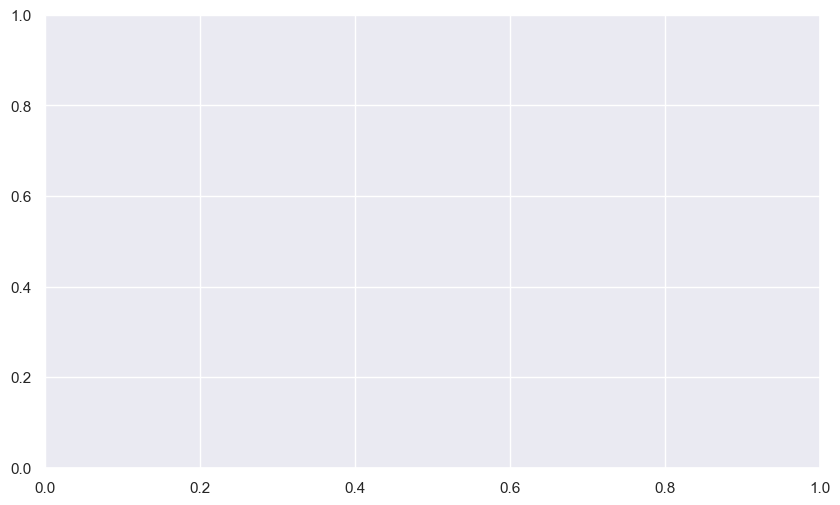

In [77]:
model1.plot('fcst')

In [ ]:
from fbprophet import Prophet
import logging
logger = logging.getLogger('fbprophet')
logger.setLevel(logging.DEBUG)

m = Prophet()
print(m.stan_backend)

In [ ]:
class Fbprophet(object):
    def fit(self,data):
        
        self.data  = data
        self.model = Prophet(weekly_seasonality=True,daily_seasonality=False,yearly_seasonality=False)
        self.model.fit(self.data)
    
    def forecast(self,periods,freq):
        
        self.future = self.model.make_future_dataframe(periods=periods,freq=freq)
        self.df_forecast = self.model.predict(self.future)
        
    def plot(self,xlabel="Years",ylabel="Values"):
        
        self.model.plot(self.df_forecast,xlabel=xlabel,ylabel=ylabel,figsize=(9,4))
        self.model.plot_components(self.df_forecast,figsize=(9,6))
        
    def R2(self):
        return r2_score(self.data.y, self.df_forecast.yhat[:len(df)])
        
#df_fbprophet  = pd.DataFrame({"ds":[],"y":[]})
df_fbprophet["ds"] = pd.to_datetime(df_time_m.index)
df_fbprophet["y"]  = df_time_m.iloc[:,0].values

model = Fbprophet()
model.fit(df_fbprophet)
model.forecast(30,"D")
model.R2()

forecast = model.df_forecast[["ds","yhat_lower","yhat_upper","yhat"]].tail(30).reset_index().set_index("ds").drop("index",axis=1)
forecast["yhat"].plot(marker=".",figsize=(10,5))
plt.fill_between(x=forecast.index, y1=forecast["yhat_lower"], y2=forecast["yhat_upper"],color="gray")
plt.legend(["forecast","Bound"],loc="upper left")
plt.title("Forecasting of Next 30 Days Cases")
plt.show()

In [ ]:
class Fbprophet(object):
    def fit(self,data):
        
        self.data  = data
        self.model = Prophet(weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=False)
        self.model.fit(self.data)
    
    def forecast(self,periods,freq):
        
        self.future = self.model.make_future_dataframe(periods=periods,freq=freq)
        self.df_forecast = self.model.predict(self.future)
        
    def plot(self,xlabel="date",ylabel="Values"):
        
        self.model.plot(self.df_forecast,xlabel=xlabel,ylabel=ylabel,figsize=(9,4))
        self.model.plot_components(self.df_forecast,figsize=(9,6))
        
    def R2(self):
        return r2_score(self.data.y, self.df_forecast.yhat[:len(df_time_m)])
        
#df_time_m  = pd.DataFrame({"ds":[],"y":[]})
df_fbprophet["ds"] = pd.to_datetime(df_time_m.index)
df_fbprophet["y"]  = df_time_m.iloc[:,0].values

model = Fbprophet()
model.fit(df_fbprophet)
model.forecast(30,"D")
model.R2()

forecast = model.df_forecast[["ds","yhat_lower","yhat_upper","yhat"]].tail(30).reset_index().set_index("ds").drop("index",axis=1)
forecast["yhat"].plot(marker=".",figsize=(10,5))
plt.fill_between(x=forecast.index, y1=forecast["yhat_lower"], y2=forecast["yhat_upper"],color="gray")
plt.legend(["forecast","Bound"],loc="upper left")
plt.title("Forecasting of Next 30 Days Cases")
plt.show()

In [ ]:
## Model with additional features

Prediction of global vaccination progress/vaccination progress by country
target = people_fully_vaccinated_per_hundred

In [ ]:
df_model = pd.read_csv('df_for_model.csv')

In [ ]:
df_model.head()

In [ ]:
df_model

In [ ]:
#check for NaNs
df_model.isnull().sum()

In [ ]:
df_model.columns

In [ ]:
#creation of features
def create_features(df_model):
    df_model['day'] = df_model['Date'].dt.day
    df_model['month'] = df_model['Date'].dt.month
    df_model['dayofweek'] = df_model['Date'].dt.dayofweek
    df_model['dayofyear'] = df_model['Date'].dt.dayofyear
    df_model['quarter'] = df_model['Date'].dt.quarter
    df_model['weekofyear'] = df_model['Date'].dt.weekofyear
    return df_model

In [ ]:
def train_dev_split(df_model, days):
    #Last days data as dev set
    date = df_model['date'].max() - dt.timedelta(days=days)
    return df_model[df_model['date'] <= date], df_model[df_model['date'] > date]

In [ ]:
test_date_min = X_test['date'].min()
test_date_max = X_test['date'].max()

In [ ]:
def avoid_data_leakage(df, date=test_date_min):
    return df[df['Date']<date]

In [ ]:
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day
df_model['date']=pd.to_datetime(df_model['date'])
#test['Date']=pd.to_datetime(test['Date'])

In [ ]:
#test['Date']=test['Date'].dt.strftime("%Y%m%d")
df_model['date']=df_model['date'].dt.strftime("%Y%m%d").astype(int)

In [ ]:
# Target is to predict progress for people vaccinated per hundred
df_model.drop(['people_vaccinated_per_hundred'], axis=1, inplace = True)

In [ ]:
# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
cat_features = list(df_model.columns[df_model.dtypes==object])
cat_features

In [ ]:
num_features = list(df_model.columns[df_model.dtypes!=object])
num_features.remove('people_fully_vaccinated_per_hundred')
num_features

In [ ]:
df_model[num_features].head()

### Split data into train and test data

In [ ]:
# Define predictors and target
y = df_model['people_fully_vaccinated_per_hundred']
X = df_model.drop('people_fully_vaccinated_per_hundred', axis=1)
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

In [ ]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [ ]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# Pipline for numerical features
num_pipeline = Pipeline([('imputer_num', SimpleImputer(strategy='0')),('std_scaler', StandardScaler())])

# Pipeline for categorical features 
cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),('1hot', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
from sklearn.compose import ColumnTransformer

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

### Modelling

#### Linear Regression

In [ ]:
# Building a full pipeline with our preprocessor and a LinearRegression Classifier
from sklearn.linear_model import LinearRegression

pipe_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', LinearRegression)
])

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
# Making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe_reg, X_train, y_train, cv=5, n_jobs=-1)

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy= 0)

In [ ]:
df_model['people_vaccinated_per_hundred'].fillna('0', inplace = True)
df_model['daily_vaccinations'].fillna('0', inplace = True)
df_model['population_density'].fillna('0', inplace = True)
df_model['gdp_per_capita'].fillna('0', inplace = True)

## Train-Test-Split

In [ ]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#, stratify=y

In [ ]:
y_test

In [ ]:
#Was ist mit Feature scaling?

### SGDClassifier - unscaled data

In [ ]:
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import cross_val_score
RSEED = 10

In [ ]:
# Fit and evaluate model without hyperparameter tuning using cross validation and unscaled data 
sgd_classifier = SGDClassifier(random_state=RSEED)
scores = cross_val_score(sgd_classifier, X_train, y_train, cv=5, n_jobs=-1)

In [ ]:
# Evaluation 
print('Score (unscaled):', round(scores.mean(), 4))

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(y_test,y_test,color='deeppink')
plt.scatter(y_test,prediction,color='dodgerblue')
plt.xlabel('Actual Target Value',fontsize=15)
plt.ylabel('Predicted Target Value',fontsize=15)
plt.title('Random Forest Regressor (R2 Score= 0.95)',fontsize=14)
plt.show()

XGBoost Regressor

In [ ]:
import xgboost as xgb

In [ ]:
xgbr= xgb.XGBRegressor(n_estimators=800, learning_rate=0.01, gamma=0, subsample=.7,
                       colsample_bytree=.7, max_depth=10,
                       min_child_weight=0, 
                       objective='reg:squarederror', nthread=-1, scale_pos_weight=1,
                       seed=27, reg_alpha=0.00006, n_jobs=-1)

In [ ]:
xgbr.fit(X_train,y_train)

In [ ]:
model = RandomForestRegressor(n_jobs=-1)
estimators = 100
model.set_params(n_estimators=estimators)

scores = []

#pipeline = Pipeline([('scaler2' , StandardScaler()), ('RandomForestRegressor: ', model)])
model = RandomForestRegressor(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)


# Fit on training data
model.fit(X_train , y_train)
#pipeline.fit(X_train , y_train)



n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]




#prediction = pipeline.predict(X_test)

#pipeline.fit(X_train, y_train)
#scores.append(pipeline.score(X_test, y_test))


RandomForestRegressor

In [ ]:
model = RandomForestRegressor(n_jobs=-1)
estimators = 100
model.set_params(n_estimators=estimators)

scores = []

pipeline = Pipeline([('scaler2' , StandardScaler()),
                        ('RandomForestRegressor: ', model)])
pipeline.fit(X_train , y_train)
prediction = pipeline.predict(X_test)

pipeline.fit(X_train, y_train)
scores.append(pipeline.score(X_test, y_test))


In [ ]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.3, 
                                         random_state = RSEED)

# Imputation of missing values
train = train.fillna(train.mean())
test = test.fillna(train.mean())

# Features for feature importances
features = list(train.columns)

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)


n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

In [ ]:
import pystan
model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
model = pystan.StanModel(model_code=model_code)  # this will take a minute
y = model.sampling(n_jobs=1).extract()['y']
y.mean()  # should be close to 0